## Calculate Interpretability Data!

## Prep for analysis

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import random 
from datetime import datetime
import pandas as pd
import os 

import sys
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/utils/')
# sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/utils/')
from exp_hp import get_hp
from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results, adjust_spines
from dataprep_utils import get_testing
sys.path.append('/glade/work/kjmayer/research/catalyst/ENSOvsMJO/interpret/')
# sys.path.append('/glade/u/home/wchapman/ENSOvsMJO/interpret/')
from Gordon_interp import getoutputvecs, confvacc, iconfcorr


# import importlib
# importlib.reload(sys.modules["Gordon_interp"])
# from Gordon_interp import getoutputvecs, confvacc, iconfcorr
# importlib.reload(sys.modules["trainGordon_utils"])
# from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('text',usetex=True)
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
dpiFig = 300.

2023-11-14 15:33:59.232829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 15:34:00.575262: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 15:34:01.300901: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/casper/23.10/spack/opt/spack/openmpi/4.1.6/oneapi/2023.2.1/dgcv/lib:/glade/u/apps/

## Functions

In [3]:
def plot_phase_space(ax):
    plt.xlabel('RMM1')
    plt.ylabel('RMM2')
    xylim=1.5
    plt.xlim(-xylim, xylim)
    plt.ylim(-xylim, xylim)
    plt.plot([-xylim, xylim], [-xylim, xylim], color = 'k')
    plt.plot([-xylim, xylim], [xylim, -xylim], color = 'k')
    plt.plot([-xylim, xylim], [0, 0], color = 'k')
    plt.plot([0, 0], [-xylim, xylim], color = 'k')
    circle1 = plt.Circle((0, 0), 1, color='k', fill=False)
    ax.add_artist(circle1)
    plt.text(-1.4, -3, '2', fontsize=10, color = 'grey')
    plt.text(1.4, -3, '3', fontsize=10, color = 'grey')
    # plt.text(-0.9, -3.8, 'Indian Ocean', fontsize=20, color = 'grey')
    plt.text(2.6, -1, '4', fontsize=10, color = 'grey')
    plt.text(2.6, 1, '5', fontsize=10, color = 'grey')
    # plt.text(3.5, -1, 'Maritime Continent', fontsize=20, color = 'grey', rotation='vertical')
    plt.text(1.4, 2.6, '6', fontsize=10, color = 'grey')
    plt.text(-1.4, 2.6, '7', fontsize=10, color = 'grey')
    # plt.text(-0.9, 3.6, 'Pacific Ocean', fontsize=20, color = 'grey')
    plt.text(-2.6, 1, '8', fontsize=10, color = 'grey')
    plt.text(-2.6, -1, '1', fontsize=10, color = 'grey')
    # plt.text(-3.8, -1, 'West. Hem. \ Africa', fontsize=20, color = 'grey', rotation='vertical')
    return ax

### Load network:

In [4]:
MODEL_DIR = '/glade/scratch/wchapman/ENSOmjo_ML_models/saved_models/'
EXP_NAME = 'default'
hps = get_hp(EXP_NAME)
# variables:
DROPOUT_RATE = hps['DROPOUT_RATE']

MODELNAME1 = 'ENSO'
RIDGE1 = hps['RIDGE1']
HIDDENS1 = hps['HIDDENS1']

MODELNAME2 = 'MJO'
RIDGE2 = hps['RIDGE2']
HIDDENS2 = hps['HIDDENS2']

BATCH_SIZE = hps['BATCH_SIZE']
N_EPOCHS = 10000
PATIENCE = hps['PATIENCE'] # number of epochs of no "improvement" before training is stopped
LR = hps['LR'] # learning rate


LEADS = np.arange(7,8)
AVGS = np.arange(5,6)
SEEDS = np.arange(1,6)

SAVE = False
Run_this_shit=True

### Analyze Data

In [163]:
# model raw predictions
# confidence vs accuracy
# model contribution fractions

for l in LEADS:
    for a in AVGS:
        print('LEAD: '+str(l)+'\nAVG: '+str(a))
        
        #check if files already exist:
        ddir_save = '/glade/scratch/kjmayer/DATA/ENSOvsMJO/data/'
        finame_confvsacc = 'confvsacc_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
        if Run_this_shit:
            print('load testing data')
            X1test, X2test, Ytest = get_testing(N_z500runmean=a,
                                                LEAD=l)

            INPUT_SHAPE1 = np.shape(X1test)[1:][0]
            INPUT_SHAPE2 = np.shape(X2test)[1:][0]

            confvsacc = np.zeros(shape=(len(SEEDS),100))

            model1_rawpreds = np.zeros(shape=(len(SEEDS),np.shape(X1test)[0],2))
            model2_rawpreds = np.zeros(shape=(len(SEEDS),np.shape(X1test)[0],2))
            model_rawpreds = np.zeros(shape=(len(SEEDS),np.shape(X1test)[0],2))
            
            model1_all_fracpred = np.zeros(shape=(len(SEEDS)))
            model2_all_fracpred = np.zeros(shape=(len(SEEDS)))
            model12_all_fracpred = np.zeros(shape=(len(SEEDS)))
            
            model1_allcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            model2_allcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            model12_allcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            
            model1_conf_fracpred = np.zeros(shape=(len(SEEDS)))
            model2_conf_fracpred = np.zeros(shape=(len(SEEDS)))
            model12_conf_fracpred = np.zeros(shape=(len(SEEDS)))
            
            model1_confcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            model2_confcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            model12_confcorr_fracpred = np.zeros(shape=(len(SEEDS)))
            
            
            for ee,s in enumerate(SEEDS):
                # ENSO MODEL
                model1, input1 = build_model(s,
                                             DROPOUT_RATE,
                                             RIDGE1,
                                             HIDDENS1,
                                             INPUT_SHAPE1,
                                             MODELNAME1)
                # MJO MODEL
                model2, input2 = build_model(s,
                                             DROPOUT_RATE,
                                             RIDGE2,
                                             HIDDENS2,
                                             INPUT_SHAPE2,
                                             MODELNAME2)   
                # COMBINE ENSO & MJO MODEL
                model = fullmodel(model1, model2,
                                  input1, input2,
                                  s)

                MODEL_FINAME = 'LEAD_'+str(l)+'_AVG_'+str(a)+'__0000'+str(s)+'.h5'
                model.load_weights(MODEL_DIR+MODEL_FINAME)

                model_rawpreds[s-1] = model.predict((X1test,X2test))                
                
                conf    = np.max(model_rawpreds[s-1],axis=-1)
                predval = np.argmax(model_rawpreds[s-1],axis=-1)
                
                # ------- confident predictions --------------------------------------------------------
                per = 80
                conf_thresh = np.percentile(conf,q=per)
                # -------- confident [i_conf_predval] --------
                i_conf_predval = np.where(conf > conf_thresh)[0]
                
                if ee == 0:
                    i_conf_mat = np.zeros([len(i_conf_predval),len(SEEDS)])
                    i_predval_mat = np.zeros([len(i_conf_predval),len(SEEDS)])
                i_conf_mat[:,ee] = i_conf_predval
                i_predval_mat[:,ee] = predval[i_conf_predval]
                print('shape :',i_conf_predval.shape)
                # ----- confidence vs accuracy for all seeds: -------------------------------------------
                confvsacc[s-1], _, _ = confvacc(confval = conf,
                                              predval = predval,
                                              Ytest   = Ytest)

                # ----- model contribution: ------------------------------------------------------------
                model1_rawpreds[s-1], model2_rawpreds[s-1] = getoutputvecs(model,
                                                                       model1,
                                                                       model2,
                                                                       X1test,
                                                                       X2test)
                # model X winning class (model X output * weight)
                model1pred = np.argmax(model1_rawpreds[s-1],axis=1)
                model2pred = np.argmax(model2_rawpreds[s-1],axis=1)

                # --------------------------------------------------------------------------------------
                # ---------- all predictions contribution: ---------------------------------------------
                # --------------------------------------------------------------------------------------
                i_model1_samefinalpred = model1pred==predval
                i_model2_samefinalpred = model2pred==predval
                
                # terminology: "win" = modelX prediction is also full model prediction
                # model X same as final prediction & model ~X does not have that prediction
                i_model1win = i_model1_samefinalpred & ~i_model2_samefinalpred
                i_model2win = i_model2_samefinalpred & ~i_model1_samefinalpred
                # model 1&2 have same final prediction
                i_model12win = i_model1_samefinalpred & i_model2_samefinalpred
                
                # number of predictions of model(X) predicted class that is also full model prediction
                n_model1win_predval = model1pred[i_model1win].shape[0]
                n_model2win_predval = model2pred[i_model2win].shape[0]
                n_model12win_predval = predval[i_model12win].shape[0]
                
                # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
                if predval.shape[0] == n_model1win_predval + n_model2win_predval + n_model12win_predval:
                    # print('SEED: '+str(s))
                    # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
                    model1_all_fracpred[s-1]  = (n_model1win_predval/predval.shape[0])
                    model2_all_fracpred[s-1]  = (n_model2win_predval/predval.shape[0])
                    model12_all_fracpred[s-1] = (n_model12win_predval/predval.shape[0])
                
                
                
                # --------------------------------------------------------------------------------------
                #  ---------- all correct predictions contribution:  -----------------------------------
                # --------------------------------------------------------------------------------------
                # Where ENSO/MJO/final model (model 1/model 2/total) are correct:
                i_model1corr = model1pred==Ytest
                i_model2corr = model2pred==Ytest
                i_modelcorr  = predval==Ytest
                
                if ee ==0:
                    i_modelcorr_mat =np.zeros([len(i_modelcorr),len(SEEDS)])
                
                i_modelcorr_mat[:,ee]=i_modelcorr

                # terminology: "win" = modelX prediction is also (correct) full model prediction
                # model X correct & model correct (model ~X not correct)
                i_model1win = i_model1corr & i_modelcorr & ~i_model2corr
                i_model2win = i_model2corr & i_modelcorr & ~i_model1corr
                # model 1&2 correct & model correct
                i_model12win = i_model1corr & i_model2corr & i_modelcorr

                # For correct predictions: model(X) values & predicted class when also full model prediction
                model1win_contribution = model1_rawpreds[s-1][i_model1win]
                model1win_predval = model1pred[i_model1win]

                model2win_contribution = model2_rawpreds[s-1][i_model2win]
                model2win_predval = model2pred[i_model2win]

                model12win_predval = model_rawpreds[s-1][i_model12win]

                # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
                if model_rawpreds[s-1][i_modelcorr].shape[0] == model1win_predval.shape[0] + model2win_predval.shape[0] + model12win_predval.shape[0]:
                    # print('SEED: '+str(s))
                    # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
                    model1_allcorr_fracpred[s-1]  = (model1win_predval.shape[0]/model_rawpreds[s-1][i_modelcorr].shape[0])
                    model2_allcorr_fracpred[s-1]  = (model2win_predval.shape[0]/model_rawpreds[s-1][i_modelcorr].shape[0])
                    model12_allcorr_fracpred[s-1] = (model12win_predval.shape[0]/model_rawpreds[s-1][i_modelcorr].shape[0])        

            
            
                # --------------------------------------------------------------------------------------
                # --------- confident predictions contribution: ----------------------------------------
                # --------------------------------------------------------------------------------------
                i_model1_samefinalconfpred = model1pred[i_conf_predval]==predval[i_conf_predval]
                i_model2_samefinalconfpred = model2pred[i_conf_predval]==predval[i_conf_predval]
                
                # terminology: "win" = modelX prediction is also full model prediction
                # model X same as final prediction & model ~X does not have that prediction
                i_model1win = i_model1_samefinalconfpred & ~i_model2_samefinalconfpred
                i_model2win = i_model2_samefinalconfpred & ~i_model1_samefinalconfpred
                # model 1&2 have same final prediction
                i_model12win = i_model1_samefinalconfpred & i_model2_samefinalconfpred
                
                
                # number of predictions of model(X) predicted class that is also full model prediction
                n_model1win_predval = model1pred[i_conf_predval][i_model1win].shape[0]
                n_model2win_predval = model2pred[i_conf_predval][i_model2win].shape[0]
                n_model12win_predval = predval[i_conf_predval][i_model12win].shape[0]

                
                # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
                if predval[i_conf_predval].shape[0] == n_model1win_predval + n_model2win_predval + n_model12win_predval:
                    # print('SEED: '+str(s))
                    # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
                    model1_conf_fracpred[s-1]  = (n_model1win_predval/predval[i_conf_predval].shape[0])
                    model2_conf_fracpred[s-1]  = (n_model2win_predval/predval[i_conf_predval].shape[0])
                    model12_conf_fracpred[s-1] = (n_model12win_predval/predval[i_conf_predval].shape[0]) 
                
                
                
                # --------------------------------------------------------------------------------------
                # --------- confident & correct predictions contribution:-------------------------------
                # --------------------------------------------------------------------------------------
                # Where ENSO/MJO/final model (model 1/model 2/total) are correct
                i_model1_confcorr = model1pred[i_conf_predval]==Ytest[i_conf_predval]
                i_model2_confcorr = model2pred[i_conf_predval]==Ytest[i_conf_predval]
                i_model_confcorr  = predval[i_conf_predval]==Ytest[i_conf_predval]

                # terminology: "win" = modelX prediction is also (correct) full model prediction
                # model X correct & model correct (model ~X not correct)
                i_model1win = i_model1_confcorr & i_model_confcorr & ~i_model2_confcorr
                i_model2win = i_model2_confcorr & i_model_confcorr & ~i_model1_confcorr
                # model 1&2 correct & model correct
                i_model12win = i_model1_confcorr & i_model2_confcorr & i_model_confcorr

                # For correct predictions: model(X) values & predicted class when also full model prediction
                n_model1win_predval = model1pred[i_conf_predval][i_model1win].shape[0]
                n_model2win_predval = model2pred[i_conf_predval][i_model2win].shape[0]
                n_model12win_predval = predval[i_conf_predval][i_model12win].shape[0]
                
                
                # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
                if predval[i_conf_predval][i_model_confcorr].shape[0] == n_model1win_predval + n_model2win_predval + n_model12win_predval:
                    # print('SEED: '+str(s))
                    # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
                    model1_confcorr_fracpred[s-1]  = (n_model1win_predval/predval[i_conf_predval][i_model_confcorr].shape[0])
                    model2_confcorr_fracpred[s-1]  = (n_model2win_predval/predval[i_conf_predval][i_model_confcorr].shape[0])
                    model12_confcorr_fracpred[s-1] = (n_model12win_predval/predval[i_conf_predval][i_model_confcorr].shape[0])
            
            if SAVE:
                print('saving')
                ddir_save = '/glade/scratch/kjmayer/DATA/ENSOvsMJO/data/'
                
                finame_confvsacc = 'confvsacc_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_confvsacc, confvsacc)

                finame_rawpred = 'model1_rawpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_rawpred, model1_rawpreds)
                finame_rawpred = 'model2_rawpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_rawpred, model2_rawpreds)
                finame_rawpred = 'model_rawpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_rawpred, model_rawpreds)

                finame_fracpred = 'model1_fracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model1_allcorr_fracpred)
                finame_fracpred = 'model2_fracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model2_allcorr_fracpred)
                finame_fracpred = 'model12_fracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model12_allcorr_fracpred)
                
                finame_fracpred = 'model1_allfracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model1_all_fracpred)
                finame_fracpred = 'model2_allfracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model2_all_fracpred)
                finame_fracpred = 'model12_allfracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model12_all_fracpred)
                
                finame_fracpred = 'model1_conffracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model1_conf_fracpred)
                finame_fracpred = 'model2_conffracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model2_conf_fracpred)
                finame_fracpred = 'model12_conffracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model12_conf_fracpred)
                
                finame_fracpred = 'model1_confcorrfracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model1_confcorr_fracpred)
                finame_fracpred = 'model2_confcorrfracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model2_confcorr_fracpred)
                finame_fracpred = 'model12_confcorrfracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
                np.save(ddir_save+finame_fracpred, model12_confcorr_fracpred)


LEAD: 7
AVG: 5
load testing data
362/362 [==============================] - 1s 1ms/step
shape : (2317,)
362/362 [==============================] - 1s 1ms/step
shape : (2317,)
362/362 [==============================] - 1s 2ms/step
shape : (2317,)
362/362 [==============================] - 1s 1ms/step
shape : (2317,)
362/362 [==============================] - 1s 1ms/step
shape : (2317,)
362/362 [==============================] - 0s 1ms/step


## Find where it is confident and correct:

In [164]:
#get confident ints
column_list = [int(element) for element in i_conf_mat[:, 0]]
correct = [int(element) for element in i_modelcorr_mat[:, 0]]
correct_and_confident = np.where(i_modelcorr_mat[column_list,0]==1)
pred_confident = i_predval_mat[correct_and_confident[0],0]
correct_and_confident_0 = correct_and_confident[0][np.where(pred_confident==0)[0]]
correct_and_confident_1 = correct_and_confident[0][np.where(pred_confident==1)[0]]

## TO DO:
    - split positive and negative predictions... this will help

In [165]:
from sklearn.cluster import KMeans
RMMs = np.array(X2test[column_list,:])

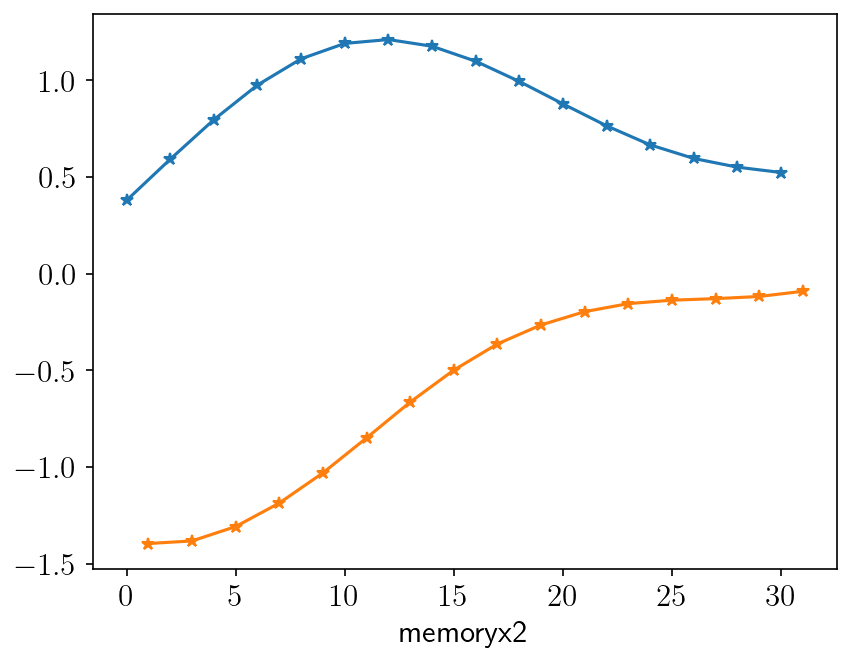

In [166]:
X2test[column_list,::2][correct_and_confident_1].mean('time').plot(marker='*')
X2test[column_list,1::2][correct_and_confident_1].mean('time').plot(marker='*')
plt.show()

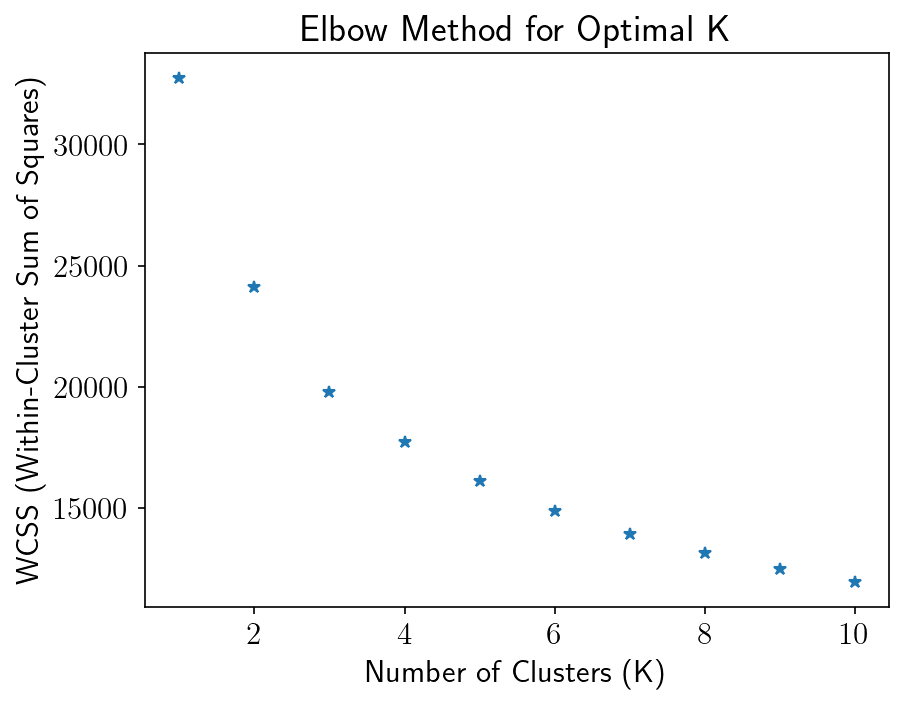

In [167]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your data into a NumPy array (assuming 'data' contains your data)
data = np.array(X2test[column_list,:][correct_and_confident_0])  # Replace with your actual data
# Step 3: Define a range of candidate values for K
k_values = range(1, 11)  # You can adjust the range

# Step 4: Calculate the WCSS for each value of K
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Step 5: Plot the WCSS graph
plt.plot(k_values, wcss,'*')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Step 6: Choose the optimal K (elbow point) based on the plot
optimal_k = 4  # Adjust this based on the plot

# Train the K-means model with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(data)

# The cluster centers are stored in kmeans.cluster_centers_
cluster_centers = kmeans.cluster_centers_


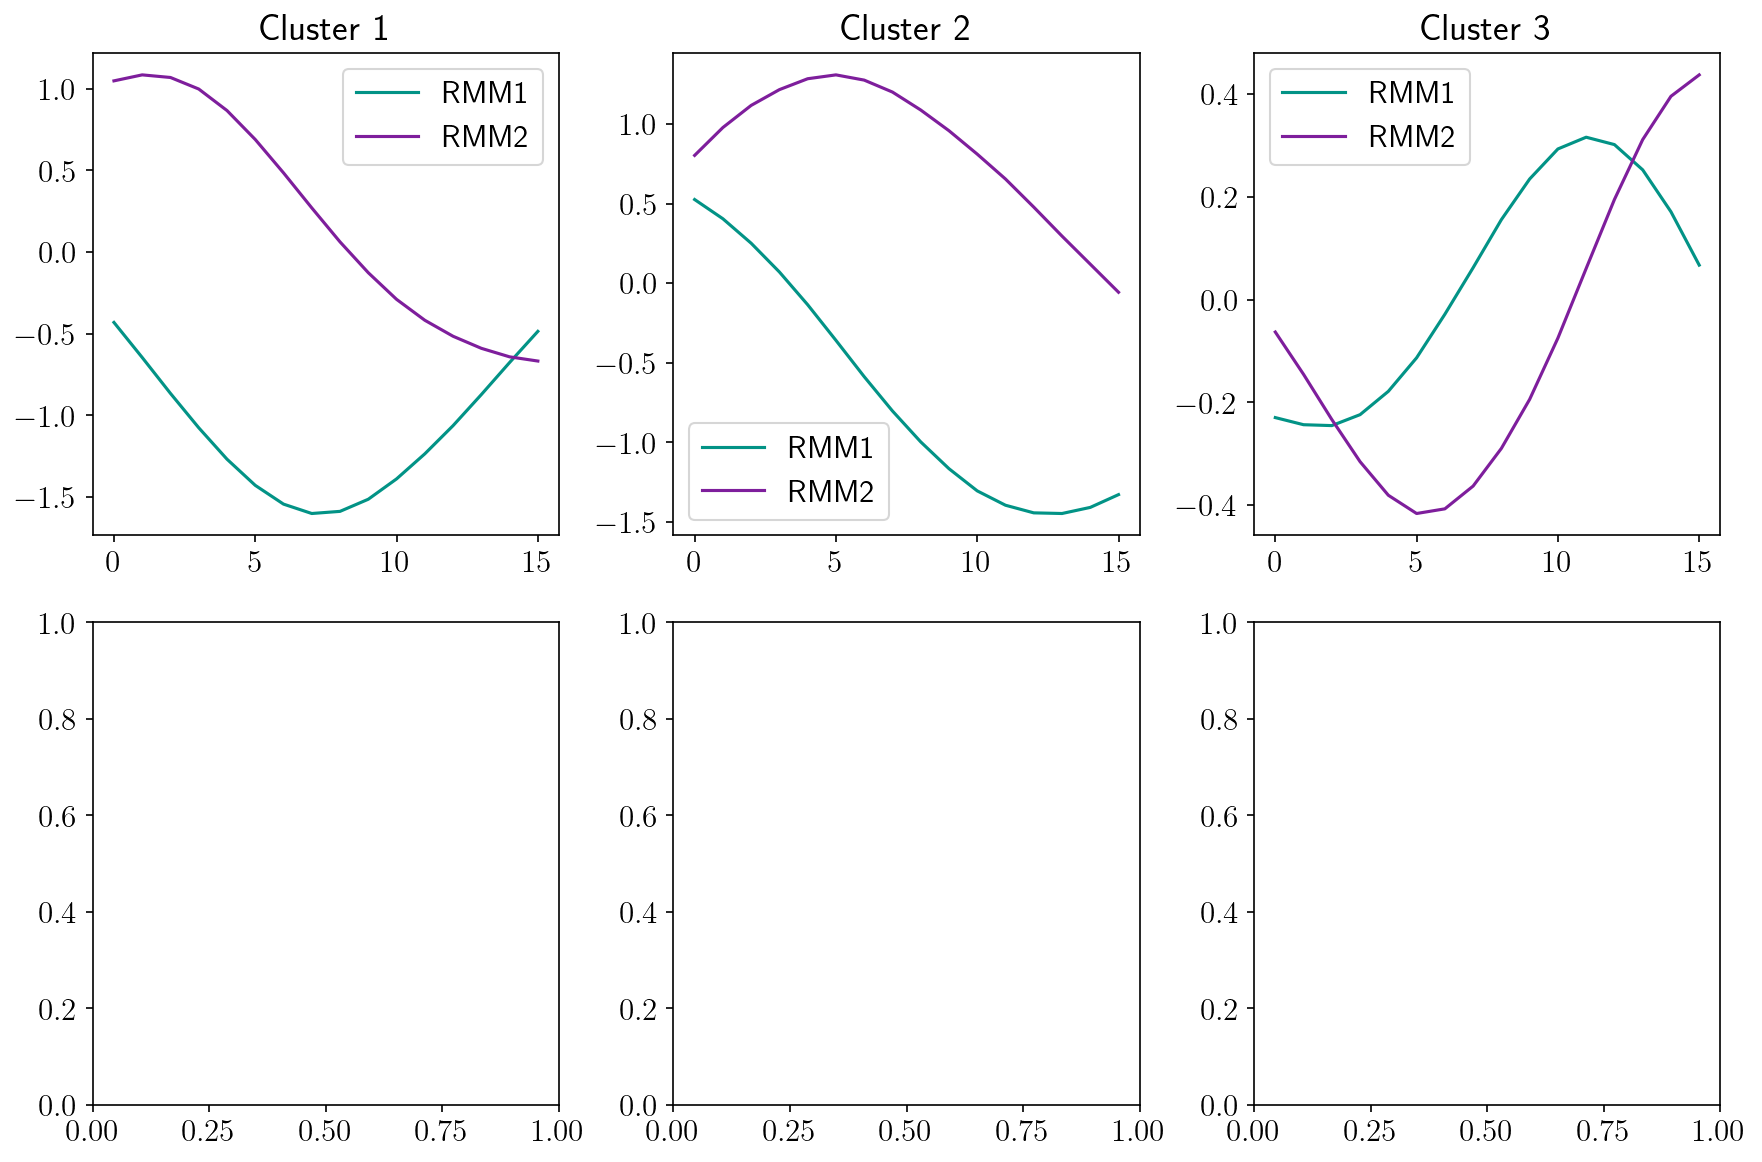

In [168]:
# Assuming you have six cluster centers and you want to plot them
cluster_centers = kmeans.cluster_centers_

# Create a 3x2 subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plot each cluster center in a separate subplot
for i in range(3):
    row = i // 3  # Row index
    col = i % 3   # Column index
    ax = axes[row, col]
    
    ax.plot(cluster_centers[i, ::2], color='xkcd:teal', label='RMM1')
    ax.plot(cluster_centers[i, 1::2], color='xkcd:purple', label='RMM2')
    ax.set_title(f'Cluster {i + 1}')
    ax.legend()
    
# Adjust spacing between subplots
plt.tight_layout()

plt.show()

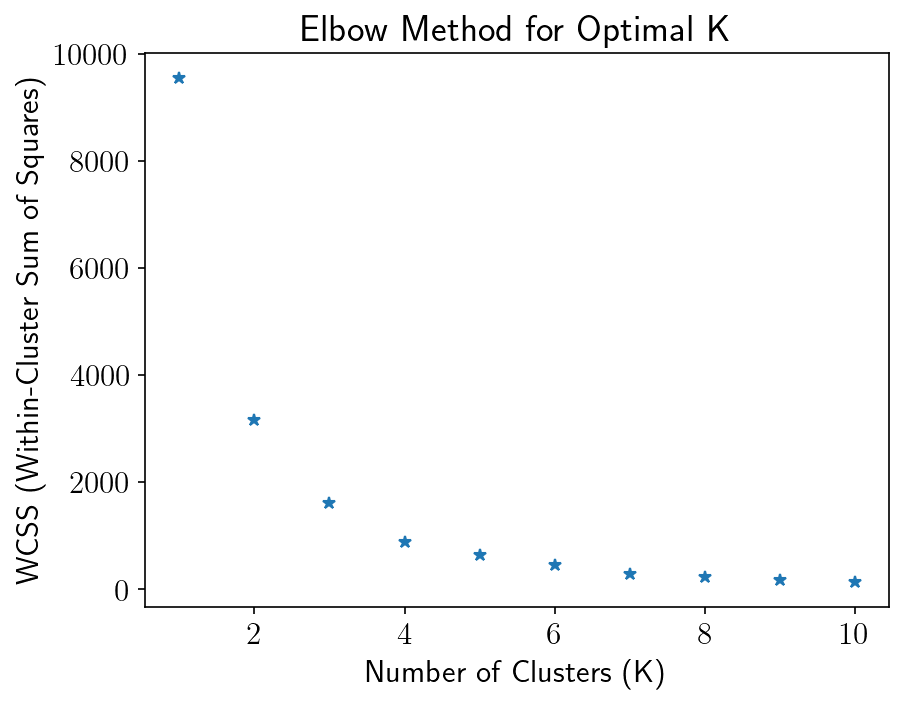

In [169]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your data into a NumPy array (assuming 'data' contains your data)
data = np.array(X1test[column_list,:][correct_and_confident_0])  # Replace with your actual data

# Step 3: Define a range of candidate values for K
k_values = range(1, 11)  # You can adjust the range

# Step 4: Calculate the WCSS for each value of K
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Step 5: Plot the WCSS graph
plt.plot(k_values, wcss,'*')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Step 6: Choose the optimal K (elbow point) based on the plot
optimal_k = 4  # Adjust this based on the plot

# Train the K-means model with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(data)

# The cluster centers are stored in kmeans.cluster_centers_
cluster_centers = kmeans.cluster_centers_


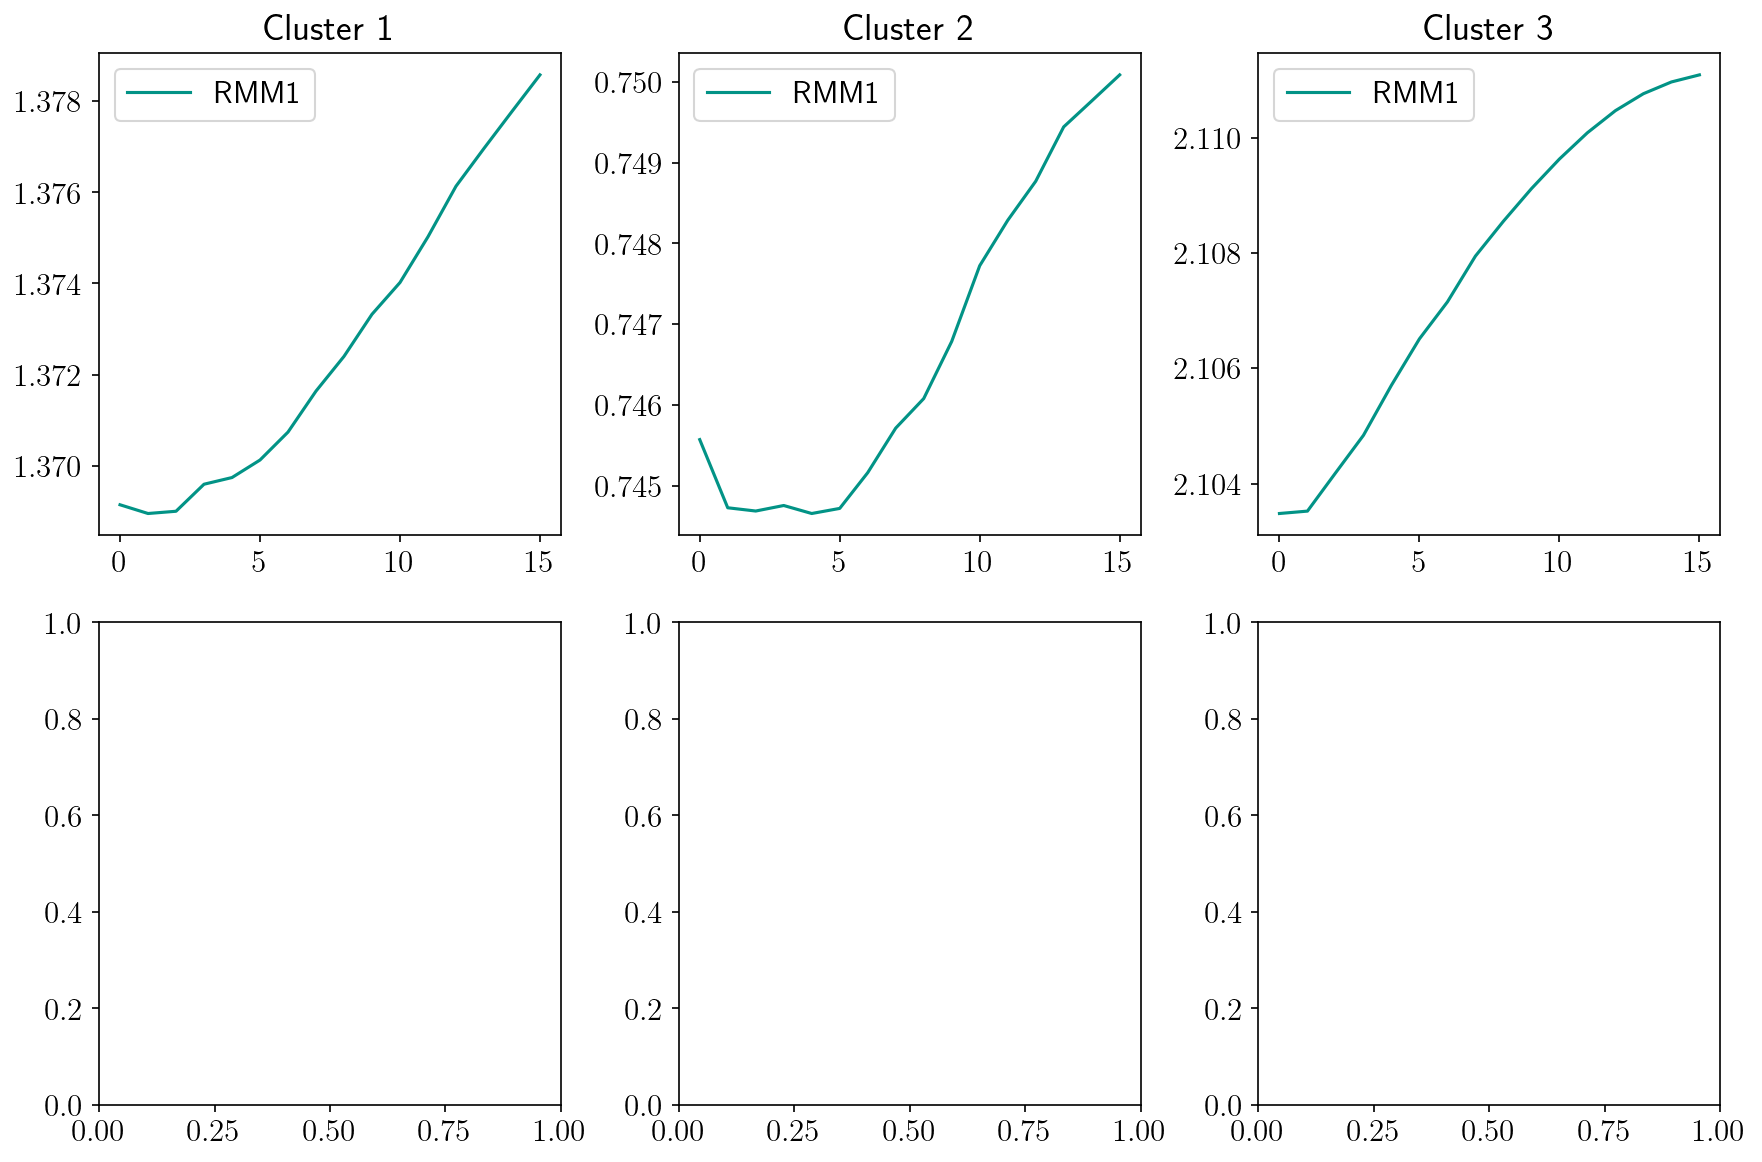

In [170]:
# Assuming you have six cluster centers and you want to plot them
cluster_centers = kmeans.cluster_centers_

# Create a 3x2 subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plot each cluster center in a separate subplot
for i in range(3):
    row = i // 3  # Row index
    col = i % 3   # Column index
    ax = axes[row, col]
    
    ax.plot(cluster_centers[i, :], color='xkcd:teal', label='RMM1')
    ax.set_title(f'Cluster {i + 1}')
    ax.legend()
    
# Adjust spacing between subplots
plt.tight_layout()

plt.show()

## Seperate by Enso State

(array([39., 50., 49., 26.,  0., 48.,  9., 14.,  0.,  3.]),
 array([-0.49988975, -0.35103318, -0.20217661, -0.05332005,  0.09553652,
         0.24439309,  0.39324966,  0.54210622,  0.69096279,  0.83981936,
         0.98867593]),
 <BarContainer object of 10 artists>)

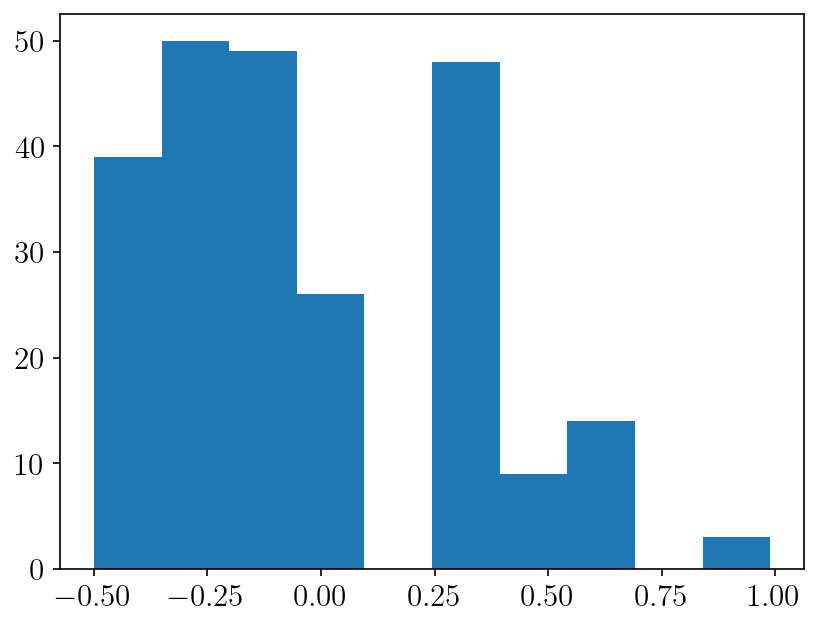

In [171]:
X3test = np.concatenate([np.expand_dims(np.mean(X1test,axis=1),axis=1),X2test],axis=1)
data = np.array(X3test[column_list,:][correct_and_confident_1])  # Replace with your actual data
indies_mjo = np.where((data[:,0]>-0.5))
plt.hist(data[indies_mjo[0],0])

In [172]:
def plot_phase_space(ax):
    # plt.xlabel('RMM1')
    # plt.ylabel('RMM2')
    xylim=2
    ax.set_xlim(-xylim, xylim)
    ax.set_ylim(-xylim, xylim)
    ax.plot([-xylim, xylim], [-xylim, xylim], color = 'k')
    ax.plot([-xylim, xylim], [xylim, -xylim], color = 'k')
    ax.plot([-xylim, xylim], [0, 0], color = 'k')
    ax.plot([0, 0], [-xylim, xylim], color = 'k')
    circle1 = plt.Circle((0, 0), 1, color='k', fill=False)
    ax.add_artist(circle1)
    ax.text(-.5, -1.5, '2', fontsize=13, color = 'grey')
    ax.text(.5, -1.5, '3', fontsize=13, color = 'grey')
    # plt.text(-0.9, -3.8, 'Indian Ocean', fontsize=20, color = 'grey')
    ax.text(1.5, -.5, '4', fontsize=13, color = 'grey')
    ax.text(1.5, .5, '5', fontsize=13, color = 'grey')
    # plt.text(3.5, -1, 'Maritime Continent', fontsize=20, color = 'grey', rotation='vertical')
    ax.text(-.5, 1.5, '7', fontsize=13, color = 'grey')
    ax.text(.5, 1.5, '6', fontsize=13, color = 'grey')
    # plt.text(-0.9, 3.6, 'Pacific Ocean', fontsize=20, color = 'grey')
    ax.text(-1.5, .5, '8', fontsize=13, color = 'grey')
    ax.text(-1.5, -.5, '1', fontsize=13, color = 'grey')
    # plt.text(-3.8, -1, 'West. Hem. \ Africa', fontsize=20, color = 'grey', rotation='vertical')
    return ax

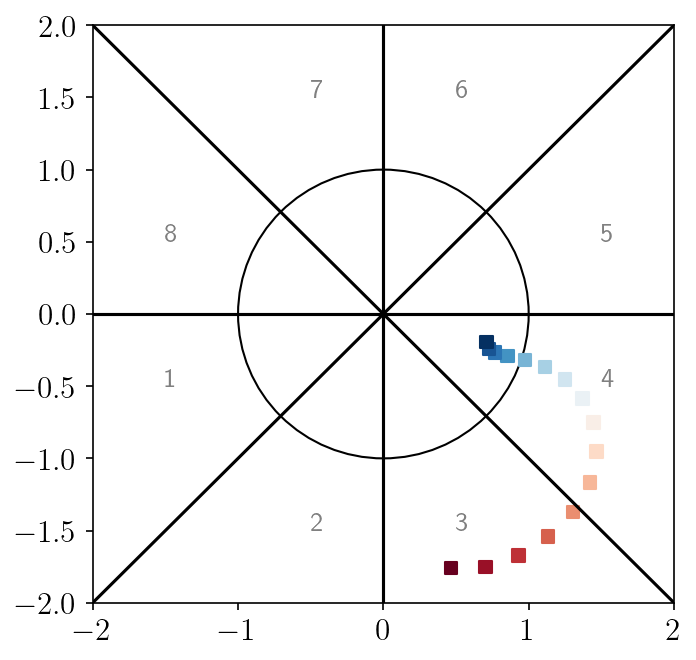

In [173]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# Create a new axis for each subplot
ax = plot_phase_space(axes)

cluster_centers= np.mean(data[indies_mjo[0],:],axis=0).squeeze()

sc = ax.scatter(
        cluster_centers[1::2],
        cluster_centers[2::2],
        marker='s',
        c=time_steps,  # Color determined by time steps
        cmap=cm.RdBu,  # Specify the colormap
        label='RMM1'
    )

In [174]:
X3test = np.concatenate([np.expand_dims(np.mean(X1test,axis=1),axis=1),X2test],axis=1)
data = np.array(X3test[column_list,:][correct_and_confident_1])  # Replace with your actual data
indies_mjo = np.where((data[:,0]>-0.5))
# Load your data into a NumPy array (assuming 'data' contains your data)
data = np.array(data[indies_mjo[0],1:])  # Replace with your actual data



In [217]:
kmeans = KMeans(n_clusters=1, random_state=0)
kmeans.fit(data)
cluster_centers = (kmeans.cluster_centers_/Wmat[0,:])

In [230]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=5, random_state=0).fit(data)
cluster_centers =gm.means_/Wmat[0,:]

## 3 Clusters justification 

La Nina then El Nino

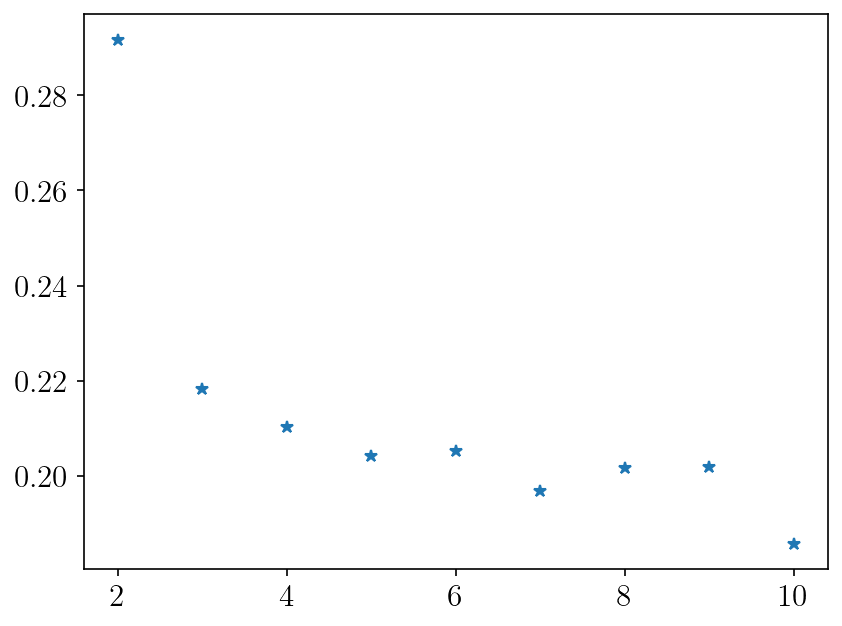

In [272]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

def get_silhouette_score(X, k):
    model = KMeans(k, random_state=42)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    return score

def get_gmm_score(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50)
    gmm.fit(X)
    gmm_scores = gmm.score_samples(X)
    score = np.exp(gmm_scores).sum()
    return score

def get_scores(X, k):
    return k, get_silhouette_score(X, k), get_gmm_score(X, k)



X3test = np.concatenate([np.expand_dims(np.mean(X1test,axis=1),axis=1),X2test],axis=1)
data = np.array(X3test[column_list,:][correct_and_confident_1])  # Replace with your actual data
indies_mjo = np.where((data[:,0]>-0.5))
# Load your data into a NumPy array (assuming 'data' contains your data)

Wmat = np.zeros_like(X3test)
Ws = np.exp(np.linspace(0,24,16))
Ws = np.exp(np.linspace(0,24,16))/np.exp(np.linspace(0,24,16))
it_up = 0 
for ii in range(33):
    if ii == 0:
        W = 1
        Wmat[:,0]=W
        continue
    if ii%2!=0:
        W = Ws[it_up]
        it_up+=1
    Wmat[:,ii]=W

# Load your data into a NumPy array (assuming 'data' contains your data)
data = np.array((X3test[column_list,:]*Wmat[column_list,:])[correct_and_confident_1])  # Replace with your actual data
data = np.array(data[indies_mjo[0],:])  # Replace with your actual data

score_df = pd.DataFrame([get_scores(data[:,:], k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])
plt.plot(score_df['k'],score_df['sil'],'*')
plt.show()

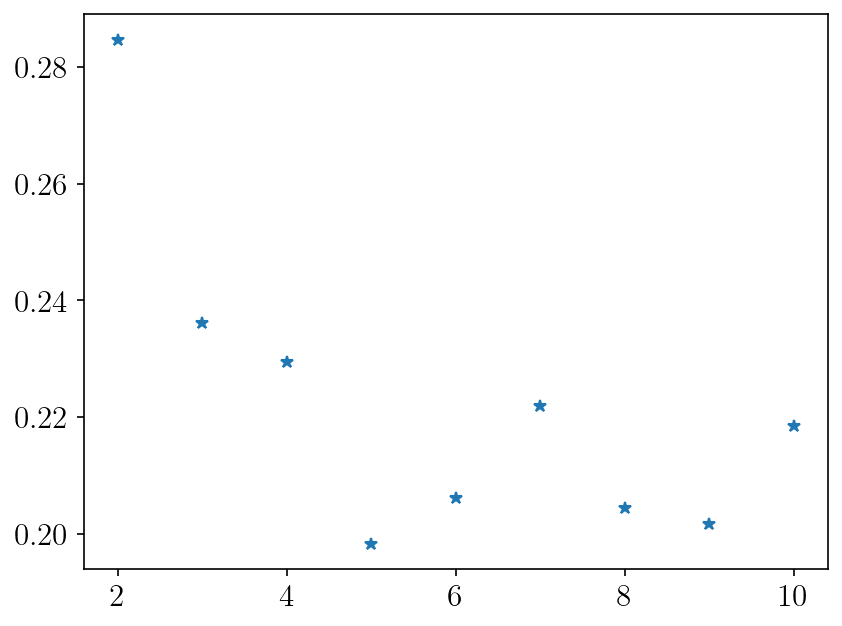

In [273]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

def get_silhouette_score(X, k):
    model = KMeans(k, random_state=42)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    return score

def get_gmm_score(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50)
    gmm.fit(X)
    gmm_scores = gmm.score_samples(X)
    score = np.exp(gmm_scores).sum()
    return score

def get_scores(X, k):
    return k, get_silhouette_score(X, k), get_gmm_score(X, k)



X3test = np.concatenate([np.expand_dims(np.mean(X1test,axis=1),axis=1),X2test],axis=1)
data = np.array(X3test[column_list,:][correct_and_confident_0])  # Replace with your actual data
indies_mjo = np.where((data[:,0]<0.5))
# Load your data into a NumPy array (assuming 'data' contains your data)

Wmat = np.zeros_like(X3test)
Ws = np.exp(np.linspace(0,24,16))
Ws = np.exp(np.linspace(0,24,16))/np.exp(np.linspace(0,24,16))
it_up = 0 
for ii in range(33):
    if ii == 0:
        W = 1
        Wmat[:,0]=W
        continue
    if ii%2!=0:
        W = Ws[it_up]
        it_up+=1
    Wmat[:,ii]=W

# Load your data into a NumPy array (assuming 'data' contains your data)
data = np.array((X3test[column_list,:]*Wmat[column_list,:])[correct_and_confident_0])  # Replace with your actual data
data = np.array(data[indies_mjo[0],:])  # Replace with your actual data

score_df = pd.DataFrame([get_scores(data[:,:], k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])
plt.plot(score_df['k'],score_df['sil'],'*')
plt.show()

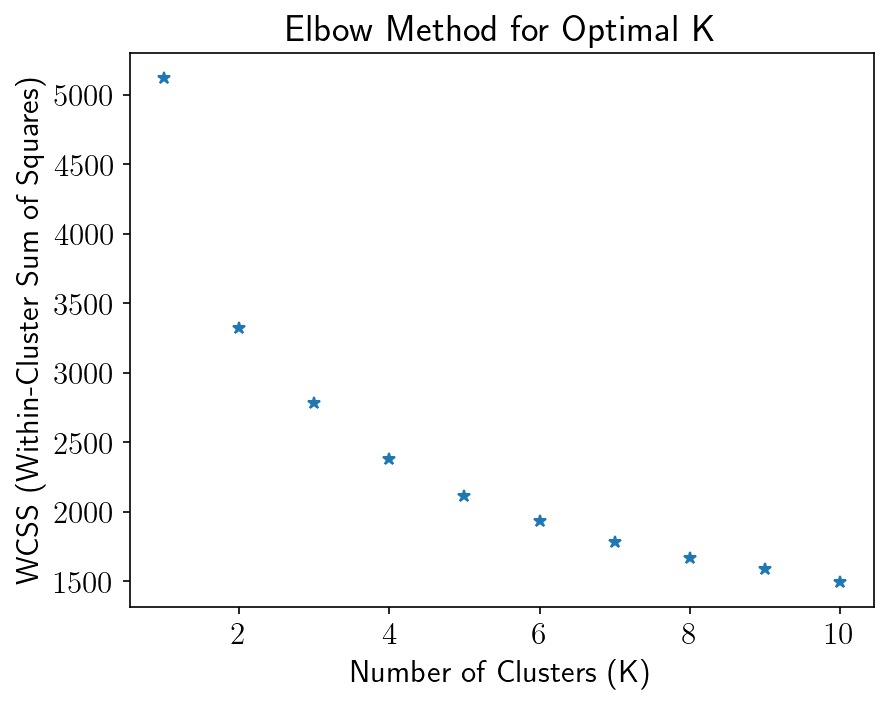

In [266]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


X3test = np.concatenate([np.expand_dims(np.mean(X1test,axis=1),axis=1),X2test],axis=1)
data = np.array(X3test[column_list,:][correct_and_confident_1])  # Replace with your actual data
indies_mjo = np.where((data[:,0]>-0.5))
# Load your data into a NumPy array (assuming 'data' contains your data)

Wmat = np.zeros_like(X3test)
Ws = np.exp(np.linspace(0,24,16))
Ws = np.exp(np.linspace(0,24,16))/np.exp(np.linspace(0,24,16))
it_up = 0 
for ii in range(33):
    if ii == 0:
        W = 1
        Wmat[:,0]=W
        continue
    if ii%2!=0:
        W = Ws[it_up]
        it_up+=1
    Wmat[:,ii]=W

# Load your data into a NumPy array (assuming 'data' contains your data)
data = np.array((X3test[column_list,:]*Wmat[column_list,:])[correct_and_confident_1])  # Replace with your actual data
data = np.array(data[indies_mjo[0],:])  # Replace with your actual data

# Step 3: Define a range of candidate values for K
k_values = range(1, 11)  # You can adjust the range

# Step 4: Calculate the WCSS for each value of K
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Step 5: Plot the WCSS graph
plt.plot(k_values, wcss,'*')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Step 6: Choose the optimal K (elbow point) based on the plot
optimal_k = 3  # Adjust this based on the plot

# Train the K-means model with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(data)

# The cluster centers are stored in kmeans.cluster_centers_
cluster_centers = (kmeans.cluster_centers_/Wmat[0,:])


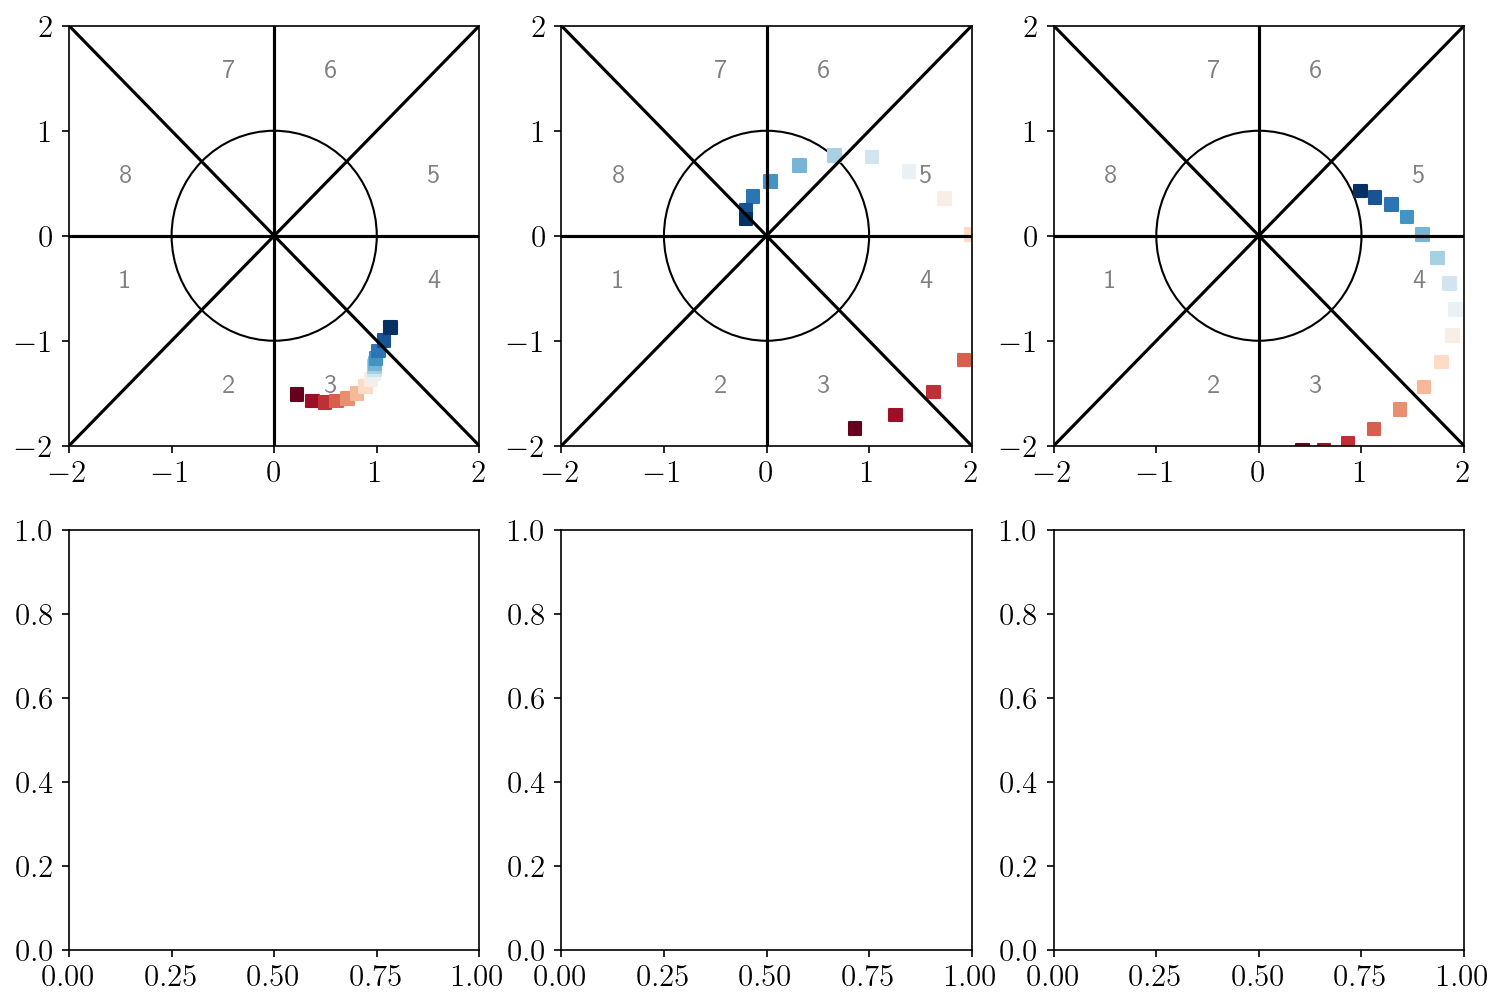

In [267]:
import matplotlib.cm as cm

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
# Assuming 'time_steps' contains your time step information
time_steps = range(len(cluster_centers[0, 1::2]))

for i in range(3):
    row = i // 3  # Row index
    col = i % 3   # Column index
    ax = axes[row, col]
    
    # Create a new axis for each subplot
    ax = plot_phase_space(ax)
    # ax.set_xlim([-4,4])
    # ax.set_ylim([-4,4])
    
    # Add any additional plots or customizations for this subplot
    # ax.plot(cluster_centers[i, :16], color='xkcd:red', label='ENSO')
    
    
    sc = ax.scatter(
        cluster_centers[i, 1::2],
        cluster_centers[i, 2::2],
        marker='s',
        c=time_steps,  # Color determined by time steps
        cmap=cm.RdBu,  # Specify the colormap
        label='RMM1'
    )
    # ax.plot(cluster_centers[i, 17::2], color='xkcd:purple', label='RMM2')
    # ax.set_title(str(int(np.round(np.sum(kmeans.labels_==i)/len(kmeans.labels_),2)*100))+'$\%$')
    # ax.legend()

plt.show()


(array([ 5.,  4.,  0.,  3.,  7.,  4., 20., 30., 22., 20.]),
 array([-1.32065043, -1.14135784, -0.96206526, -0.78277267, -0.60348009,
        -0.4241875 , -0.24489492, -0.06560233,  0.11369025,  0.29298283,
         0.47227542]),
 <BarContainer object of 10 artists>)

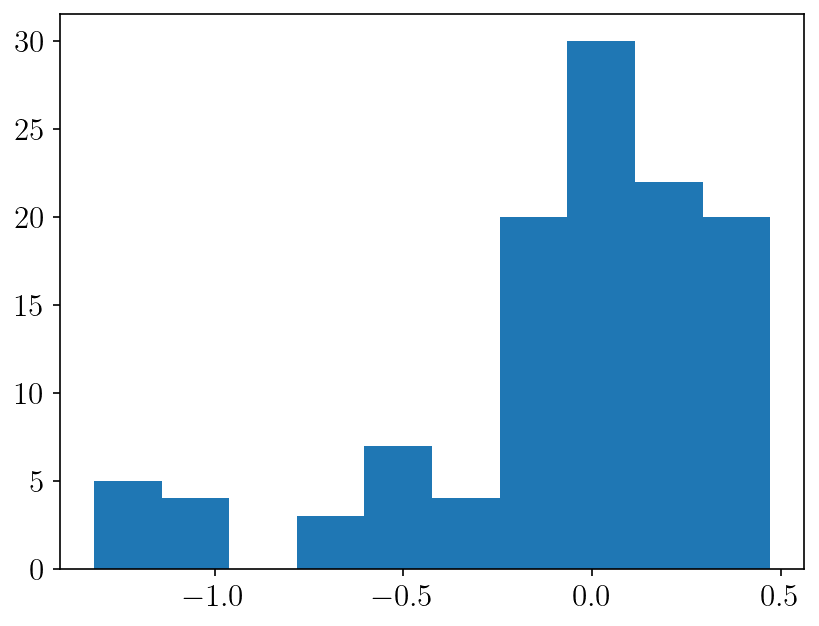

In [195]:
X3test = np.concatenate([np.expand_dims(np.mean(X1test,axis=1),axis=1),X2test],axis=1)
data = np.array(X3test[column_list,:][correct_and_confident_0])  # Replace with your actual data
indies_mjo = np.where((data[:,0]<0.5))
plt.hist(data[indies_mjo[0],0])

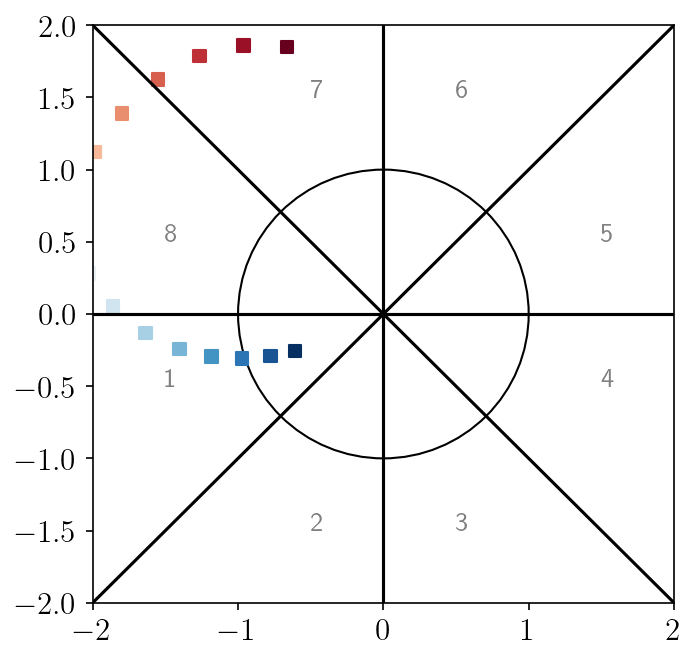

In [196]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# Create a new axis for each subplot
ax = plot_phase_space(axes)

cluster_centers= np.mean(data[indies_mjo[0],:],axis=0).squeeze()

sc = ax.scatter(
        cluster_centers[1::2],
        cluster_centers[2::2],
        marker='s',
        c=time_steps,  # Color determined by time steps
        cmap=cm.RdBu,  # Specify the colormap
        label='RMM1'
    )

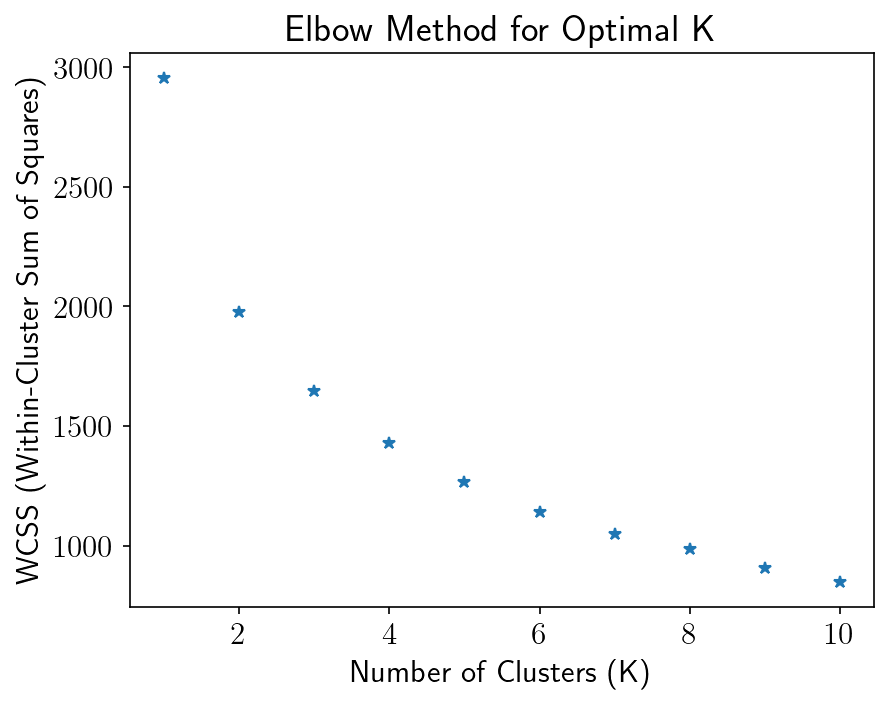

In [200]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


X3test = np.concatenate([np.expand_dims(np.mean(X1test,axis=1),axis=1),X2test],axis=1)
data = np.array(X3test[column_list,:][correct_and_confident_0])  # Replace with your actual data
indies_mjo = np.where((data[:,0]<0.5))
# Load your data into a NumPy array (assuming 'data' contains your data)

Wmat = np.zeros_like(X3test)
Ws = np.exp(np.linspace(0,24,16))
Ws = np.exp(np.linspace(0,24,16))/np.exp(np.linspace(0,24,16))
it_up = 0 
for ii in range(33):
    if ii == 0:
        W = 1
        Wmat[:,0]=W
        continue
    if ii%2!=0:
        W = Ws[it_up]
        it_up+=1
    Wmat[:,ii]=W

# Load your data into a NumPy array (assuming 'data' contains your data)
data = np.array((X3test[column_list,:]*Wmat[column_list,:])[correct_and_confident_0])  # Replace with your actual data
data = np.array(data[indies_mjo[0],:])  # Replace with your actual data

# Step 3: Define a range of candidate values for K
k_values = range(1, 11)  # You can adjust the range

# Step 4: Calculate the WCSS for each value of K
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Step 5: Plot the WCSS graph
plt.plot(k_values, wcss,'*')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Step 6: Choose the optimal K (elbow point) based on the plot
optimal_k = 2  # Adjust this based on the plot

# Train the K-means model with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(data)

# The cluster centers are stored in kmeans.cluster_centers_
cluster_centers = (kmeans.cluster_centers_/Wmat[0,:])


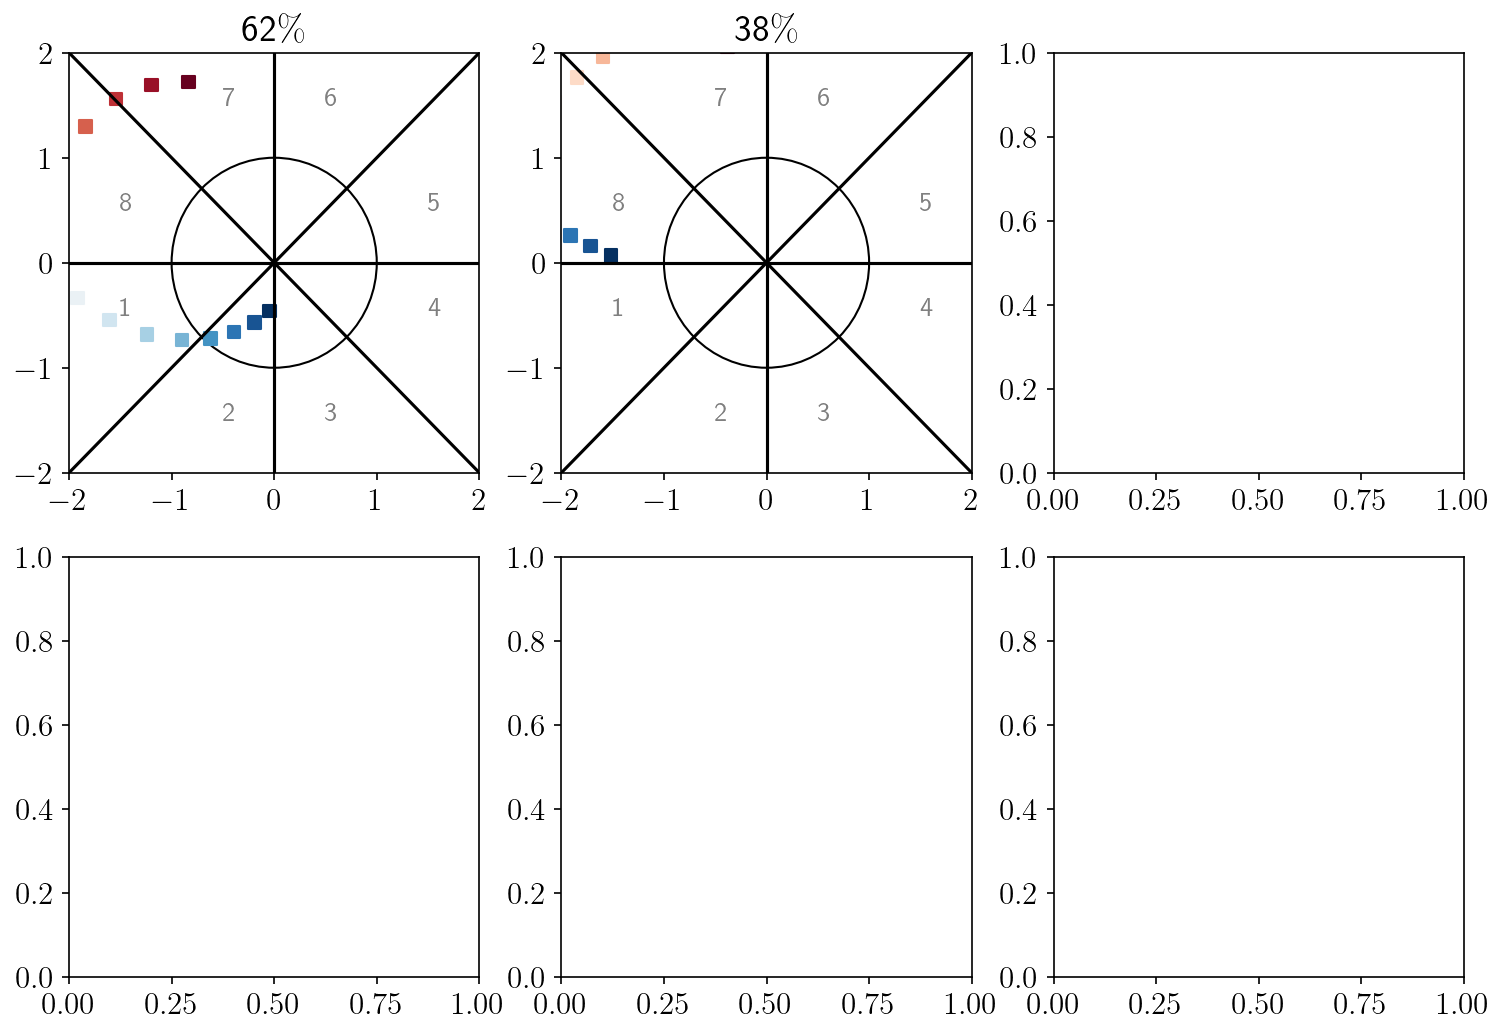

In [210]:
import matplotlib.cm as cm

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
# Assuming 'time_steps' contains your time step information
time_steps = range(len(cluster_centers[0, 1::2]))

for i in range(2):
    row = i // 3  # Row index
    col = i % 3   # Column index
    ax = axes[row, col]
    
    # Create a new axis for each subplot
    ax = plot_phase_space(ax)
    # ax.set_xlim([-4,4])
    # ax.set_ylim([-4,4])
    
    # Add any additional plots or customizations for this subplot
    # ax.plot(cluster_centers[i, :16], color='xkcd:red', label='ENSO')
    
    
    sc = ax.scatter(
        cluster_centers[i, 1::2],
        cluster_centers[i, 2::2],
        marker='s',
        c=time_steps,  # Color determined by time steps
        cmap=cm.RdBu,  # Specify the colormap
        label='RMM1'
    )
    # ax.plot(cluster_centers[i, 17::2], color='xkcd:purple', label='RMM2')
    ax.set_title(str(int(np.round(np.sum(kmeans.labels_==i)/len(kmeans.labels_),2)*100))+'$\%$')
    # ax.legend()

plt.show()


In [211]:
cluster_centers[i, 1::2]

array([-0.37947856, -0.58489079, -0.81928693, -1.09076676, -1.34609277,
       -1.59270547, -1.8488292 , -2.06486269, -2.20931836, -2.27832661,
       -2.27497074, -2.2106537 , -2.08420936, -1.91259665, -1.71582593,
       -1.5177687 ])

## Create a weighting matrix! 

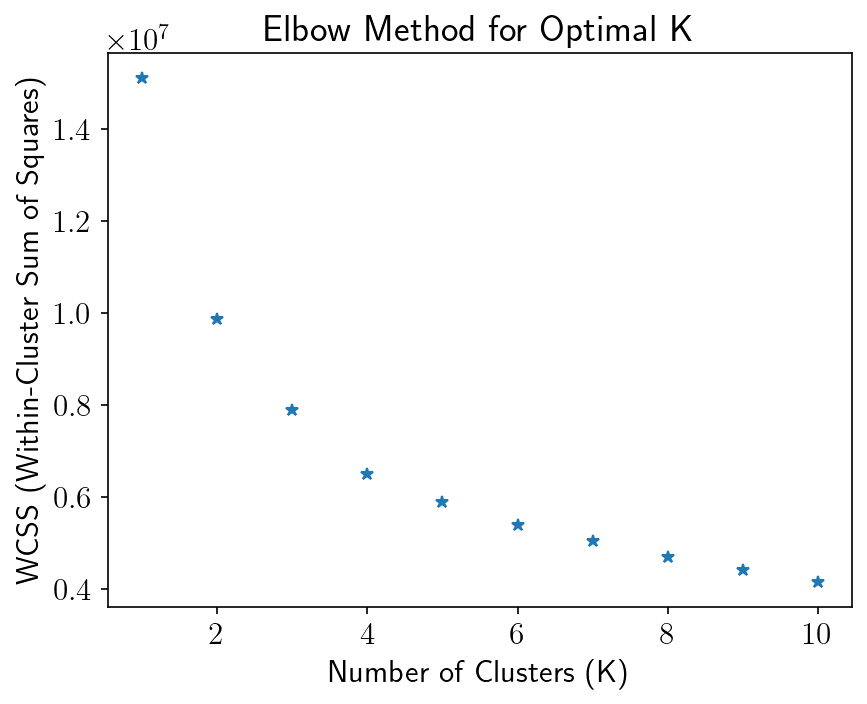

In [15]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#create a weighting matrix
X3test = np.concatenate([np.expand_dims(np.mean(X1test,axis=1),axis=1),X2test],axis=1)

Wmat = np.zeros_like(X3test)
Ws = np.linspace(10,50,16)
it_up = 0 
for ii in range(33):
    if ii == 0:
        W = 1
        Wmat[:,0]=W
        continue
    if ii%2!=0:
        W = Ws[it_up]
        it_up+=1
    Wmat[:,ii]=W


# Load your data into a NumPy array (assuming 'data' contains your data)
data = np.array((X3test[column_list,:]*Wmat[column_list,:])[correct_and_confident_1])  # Replace with your actual data

# Step 3: Define a range of candidate values for K
k_values = range(1, 11)  # You can adjust the range

# Step 4: Calculate the WCSS for each value of K
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Step 5: Plot the WCSS graph
plt.plot(k_values, wcss,'*')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Step 6: Choose the optimal K (elbow point) based on the plot
optimal_k = 2  # Adjust this based on the plot

# Train the K-means model with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(data)

# The cluster centers are stored in kmeans.cluster_centers_
cluster_centers = (kmeans.cluster_centers_/Wmat[0,:])


In [248]:
kmeans

KMeans(n_clusters=2, random_state=0)

In [16]:
def plot_phase_space(ax):
    # plt.xlabel('RMM1')
    # plt.ylabel('RMM2')
    xylim=2
    ax.set_xlim(-xylim, xylim)
    ax.set_ylim(-xylim, xylim)
    ax.plot([-xylim, xylim], [-xylim, xylim], color = 'k')
    ax.plot([-xylim, xylim], [xylim, -xylim], color = 'k')
    ax.plot([-xylim, xylim], [0, 0], color = 'k')
    ax.plot([0, 0], [-xylim, xylim], color = 'k')
    circle1 = plt.Circle((0, 0), 1, color='k', fill=False)
    ax.add_artist(circle1)
    ax.text(-.5, -1.5, '2', fontsize=13, color = 'grey')
    ax.text(.5, -1.5, '3', fontsize=13, color = 'grey')
    # plt.text(-0.9, -3.8, 'Indian Ocean', fontsize=20, color = 'grey')
    ax.text(1.5, -.5, '4', fontsize=13, color = 'grey')
    ax.text(1.5, .5, '5', fontsize=13, color = 'grey')
    # plt.text(3.5, -1, 'Maritime Continent', fontsize=20, color = 'grey', rotation='vertical')
    ax.text(-.5, 1.5, '7', fontsize=13, color = 'grey')
    ax.text(.5, 1.5, '6', fontsize=13, color = 'grey')
    # plt.text(-0.9, 3.6, 'Pacific Ocean', fontsize=20, color = 'grey')
    ax.text(-1.5, .5, '8', fontsize=13, color = 'grey')
    ax.text(-1.5, -.5, '1', fontsize=13, color = 'grey')
    # plt.text(-3.8, -1, 'West. Hem. \ Africa', fontsize=20, color = 'grey', rotation='vertical')
    return ax

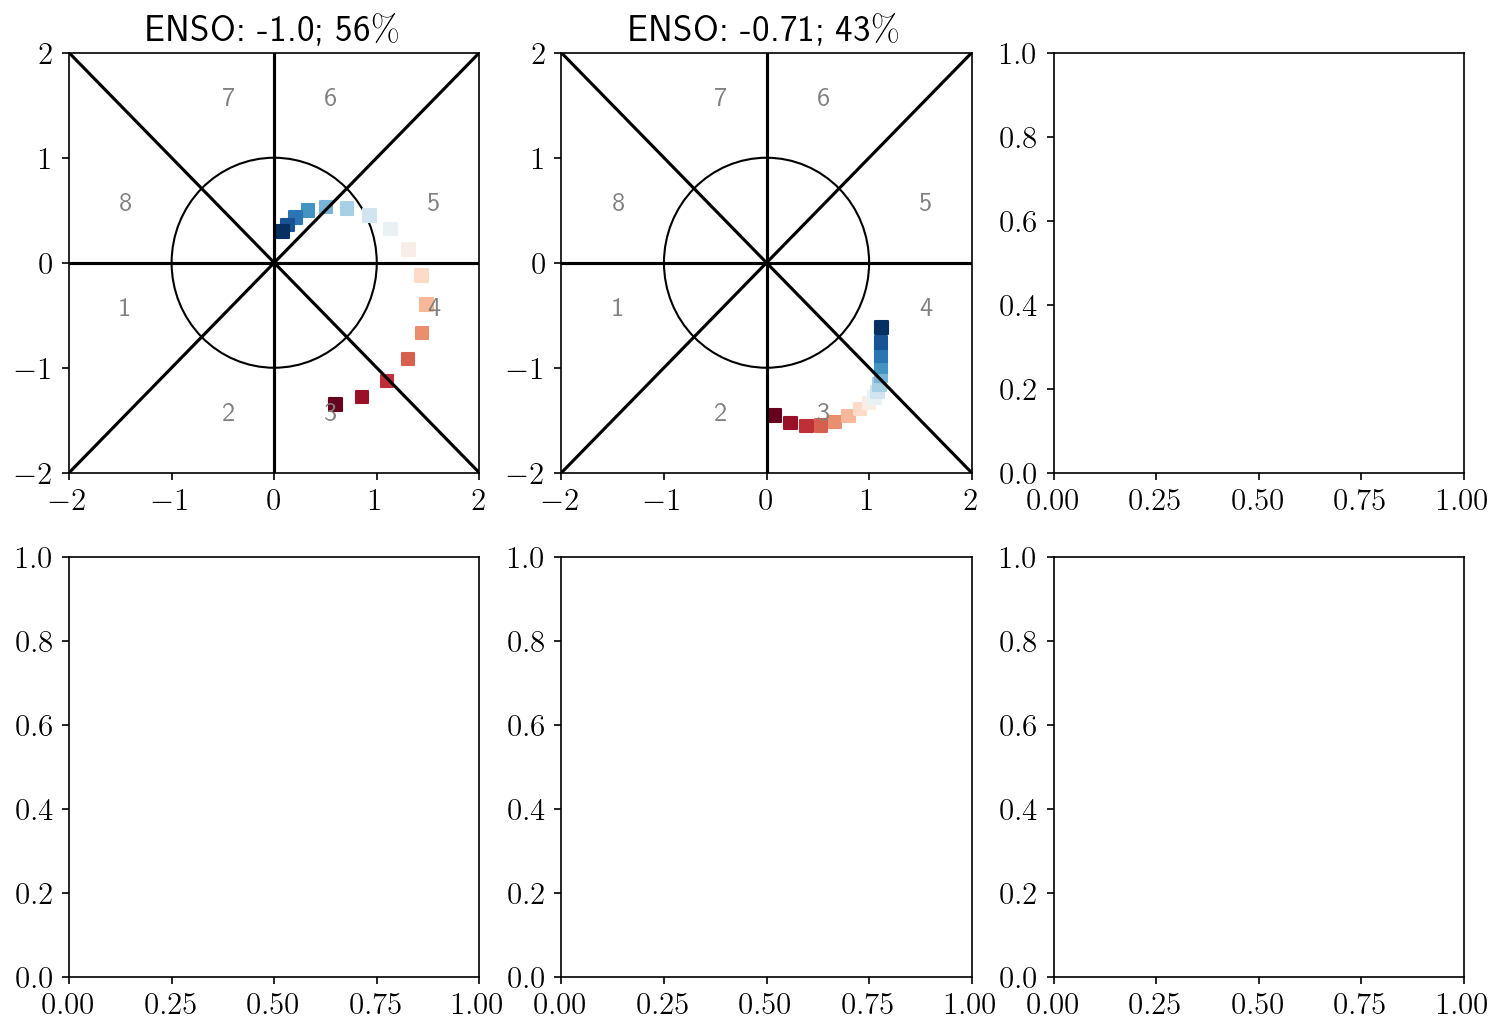

In [17]:
import matplotlib.cm as cm

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
# Assuming 'time_steps' contains your time step information
time_steps = range(len(cluster_centers[0, 1::2]))

for i in range(2):
    row = i // 3  # Row index
    col = i % 3   # Column index
    ax = axes[row, col]
    
    # Create a new axis for each subplot
    ax = plot_phase_space(ax)
    # ax.set_xlim([-4,4])
    # ax.set_ylim([-4,4])
    
    # Add any additional plots or customizations for this subplot
    # ax.plot(cluster_centers[i, :16], color='xkcd:red', label='ENSO')
    
    
    sc = ax.scatter(
        cluster_centers[i, 1::2],
        cluster_centers[i, 2::2],
        marker='s',
        c=time_steps,  # Color determined by time steps
        cmap=cm.RdBu,  # Specify the colormap
        label='RMM1'
    )
    # ax.plot(cluster_centers[i, 17::2], color='xkcd:purple', label='RMM2')
    ax.set_title(f'ENSO: {np.round((cluster_centers[i, 0]),2)}'+'; '+str(int(np.round(np.sum(kmeans.labels_==i)/len(kmeans.labels_),2)*100))+'$\%$')
    # ax.legend()

plt.show()


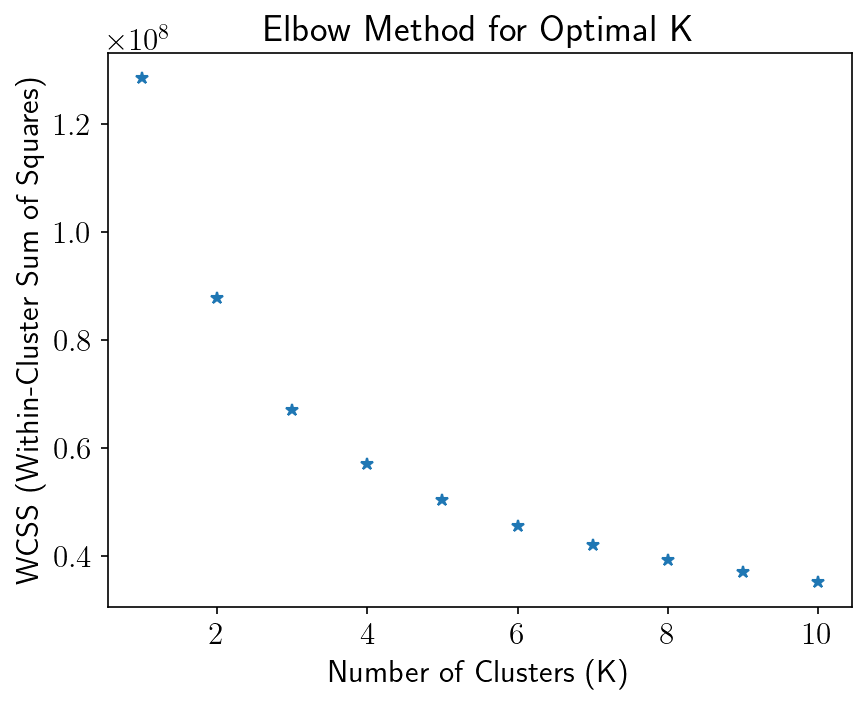

In [198]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#create a weighting matrix
Wmat = np.zeros_like(X3test)
Ws = np.linspace(10,100,16)
it_up = 0 
for ii in range(33):
    if ii == 0:
        W = 1
        Wmat[:,0]=W
        continue
    if ii%2!=0:
        W = Ws[it_up]
        it_up+=1
    Wmat[:,ii]=W


X3test = np.concatenate([np.expand_dims(np.mean(X1test,axis=1),axis=1),X2test],axis=1)
# Load your data into a NumPy array (assuming 'data' contains your data)
data = np.array((X3test[column_list,:]*Wmat[column_list,:])[correct_and_confident_0])  # Replace with your actual data

# Step 3: Define a range of candidate values for K
k_values = range(1, 11)  # You can adjust the range

# Step 4: Calculate the WCSS for each value of K
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

# Step 5: Plot the WCSS graph
plt.plot(k_values, wcss,'*')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

# Step 6: Choose the optimal K (elbow point) based on the plot
optimal_k = 2  # Adjust this based on the plot

# Train the K-means model with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(data)

# The cluster centers are stored in kmeans.cluster_centers_
cluster_centers = (kmeans.cluster_centers_/Wmat[0,:])


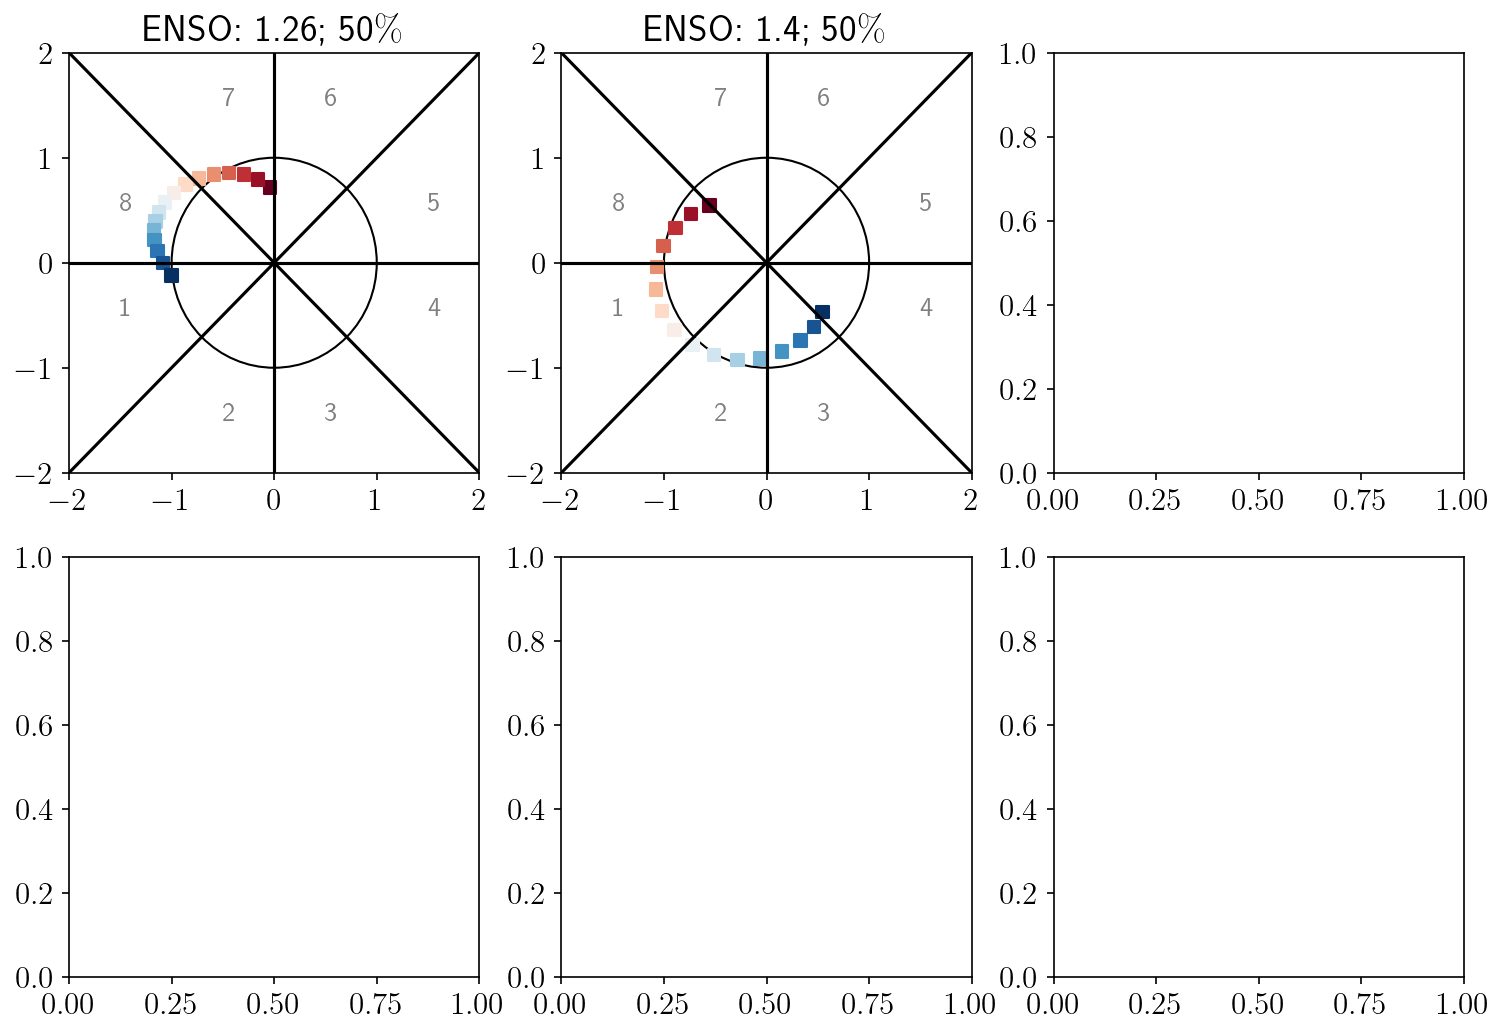

In [199]:
import matplotlib.cm as cm

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
# Assuming 'time_steps' contains your time step information
time_steps = range(len(cluster_centers[0, 1::2]))

for i in range(2):
    row = i // 3  # Row index
    col = i % 3   # Column index
    ax = axes[row, col]
    
    # Create a new axis for each subplot
    ax = plot_phase_space(ax)
    # ax.set_xlim([-4,4])
    # ax.set_ylim([-4,4])
    
    # Add any additional plots or customizations for this subplot
    # ax.plot(cluster_centers[i, :16], color='xkcd:red', label='ENSO')
    
    
    sc = ax.scatter(
        cluster_centers[i, 1::2],
        cluster_centers[i, 2::2],
        marker='s',
        c=time_steps,  # Color determined by time steps
        cmap=cm.RdBu,  # Specify the colormap
        label='RMM1'
    )
    # ax.plot(cluster_centers[i, 17::2], color='xkcd:purple', label='RMM2')
    ax.set_title(f'ENSO: {np.round((cluster_centers[i, 0]),2)}'+'; '+str(int(np.round(np.sum(kmeans.labels_==i)/len(kmeans.labels_),2)*100))+'$\%$')
    # ax.legend()

plt.show()


# DO THIS Instead !!!!!!!!!: 

- rather than doing a kmeans just set a threshold for ENSO / la Nina (0.5,-.5) Neutral conditions and composite on CONFINDENT CORRECT Positive and Confident Correct Negative

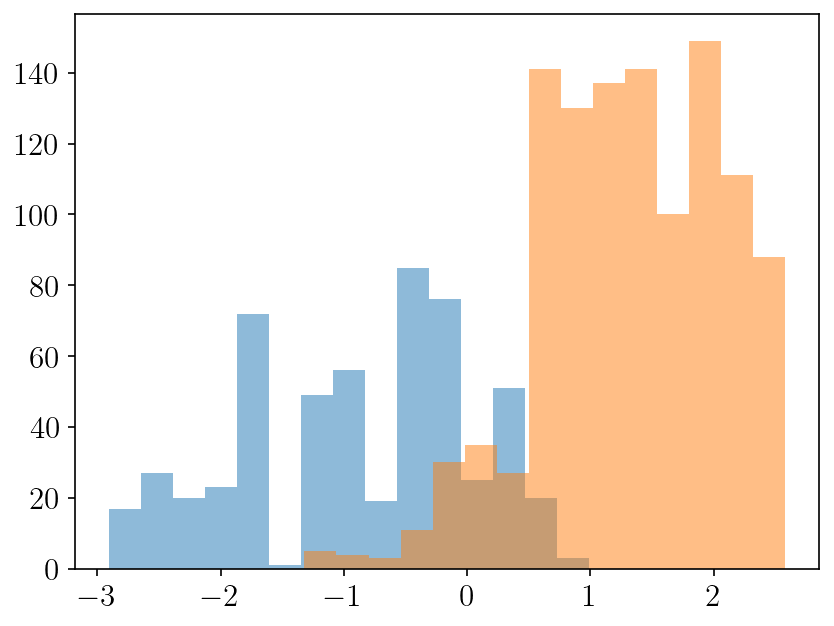

In [197]:
data = np.array((X3test[column_list,:]*Wmat[column_list,:])[correct_and_confident_1])  # Replace with your actual data
plt.hist(data[:,0],15,alpha=0.5)
data = np.array((X3test[column_list,:]*Wmat[column_list,:])[correct_and_confident_0])  # Replace with your actual data
plt.hist(data[:,0],15,alpha=0.5)
plt.show()

In [ ]:
kmeans

KMeans(n_clusters=3, random_state=0)

### Old Version:

In [7]:
# # model raw predictions
# # confidence vs accuracy
# # model contribution fraction (correct)
# for l in LEADS:
#     print('LEAD: '+str(l))
#     for a in AVGS:
#         print('AVG: '+str(a))
        
#         #check if files already exist:
#         ddir_save = '/glade/work/kjmayer/research/catalyst/ENSOvsMJO/data/'
#         finame_confvsacc = 'confvsacc_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#         if not os.path.isfile(ddir_save+finame_confvsacc):
#             print('load testing data')
#             X1test, X2test, Ytest = get_testing(N_z500runmean=a,
#                                                 LEAD=l)

#             INPUT_SHAPE1 = np.shape(X1test)[1:][0]
#             INPUT_SHAPE2 = np.shape(X2test)[1:][0]

#             confvsacc = np.zeros(shape=(len(SEEDS),100))

#             model1_rawpreds = np.zeros(shape=(len(SEEDS),np.shape(X1test)[0],2))
#             model2_rawpreds = np.zeros(shape=(len(SEEDS),np.shape(X1test)[0],2))
#             model_rawpreds = np.zeros(shape=(len(SEEDS),np.shape(X1test)[0],2))

#             model1_fracpred = np.zeros(shape=(len(SEEDS)))
#             model2_fracpred = np.zeros(shape=(len(SEEDS)))
#             model12_fracpred = np.zeros(shape=(len(SEEDS)))

#             for s in SEEDS:
#                 # ENSO MODEL
#                 model1, input1 = build_model(s,
#                                              DROPOUT_RATE,
#                                              RIDGE1,
#                                              HIDDENS1,
#                                              INPUT_SHAPE1,
#                                              MODELNAME1)
#                 # MJO MODEL
#                 model2, input2 = build_model(s,
#                                              DROPOUT_RATE,
#                                              RIDGE2,
#                                              HIDDENS2,
#                                              INPUT_SHAPE2,
#                                              MODELNAME2)   
#                 # COMBINE ENSO & MJO MODEL
#                 model = fullmodel(model1, model2,
#                                   input1, input2,
#                                   s)

#                 MODEL_FINAME = 'LEAD_'+str(l)+'_AVG_'+str(a)+'__0000'+str(s)+'.h5'
#                 model.load_weights(MODEL_DIR+MODEL_FINAME)

#                 model_rawpreds[s-1] = model.predict((X1test,X2test))
#                 conf    = np.max(model_rawpreds[s-1],axis=-1)
#                 predval = np.argmax(model_rawpreds[s-1],axis=-1)

#                 # ----- confidence vs accuracy for all seeds:
#                 confvsacc[s-1], _, _ = confvacc(confval = conf,
#                                               predval = predval,
#                                               Ytest   = Ytest)

#                 # ----- model contribution:
#                 model1_rawpreds[s-1], model2_rawpreds[s-1] = getoutputvecs(model,
#                                                                        model1,
#                                                                        model2,
#                                                                        X1test,
#                                                                        X2test)
#                 # model X winning class (model X output * weight)
#                 model1pred = np.argmax(model1_rawpreds[s-1],axis=1)
#                 model2pred = np.argmax(model2_rawpreds[s-1],axis=1)

#                 # Where ENSO/MJO/final model (model 1/model 2/total) are correct
#                 i_model1corr = model1pred==Ytest
#                 i_model2corr = model2pred==Ytest
#                 i_modelcorr  = predval==Ytest

#                 # terminology: "win" = modelX prediction is also (correct) full model prediction
#                 # model X correct & model correct (model ~X not correct)
#                 i_model1win = i_model1corr & i_modelcorr & ~i_model2corr
#                 i_model2win = i_model2corr & i_modelcorr & ~i_model1corr
#                 # model 1&2 correct & model correct
#                 i_model12win = i_model1corr & i_model2corr & i_modelcorr

#                 # For correct predictions: model(X) values & predicted class when also full model prediction
#                 model1win_contribution = model1_rawpreds[s-1][i_model1win]
#                 model1win_predval = model1pred[i_model1win]

#                 model2win_contribution = model2_rawpreds[s-1][i_model2win]
#                 model2win_predval = model2pred[i_model2win]

#                 model12win_predval = model_rawpreds[s-1][i_model12win]

#                 # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
#                 if model_rawpreds[s-1][i_modelcorr].shape[0] == model1win_predval.shape[0] + model2win_predval.shape[0] + model12win_predval.shape[0]:
#                     print('SEED: '+str(s))
#                     # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
#                     model1_fracpred[s-1]  = (model1win_predval.shape[0]/model_rawpreds[s-1][i_modelcorr].shape[0])
#                     model2_fracpred[s-1]  = (model2win_predval.shape[0]/model_rawpreds[s-1][i_modelcorr].shape[0])
#                     model12_fracpred[s-1] = (model12win_predval.shape[0]/model_rawpreds[s-1][i_modelcorr].shape[0])        

#             if SAVE:
#                 print('saving')
#                 ddir_save = '/glade/work/kjmayer/research/catalyst/ENSOvsMJO/data/'
                
#                 finame_confvsacc = 'confvsacc_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_confvsacc, confvsacc)

#                 finame_rawpred = 'model1_rawpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_rawpred, model1_rawpreds)
#                 finame_rawpred = 'model2_rawpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_rawpred, model2_rawpreds)
#                 finame_rawpred = 'model_rawpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_rawpred, model_rawpreds)

#                 finame_fracpred = 'model1_fracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model1_fracpred)
#                 finame_fracpred = 'model2_fracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model2_fracpred)
#                 finame_fracpred = 'model12_fracpred_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model12_fracpred)


In [5]:
# # model contribution fraction:
# #    all predictions (not just correct)
# #    confident predictions
# #    correct & confident predictions

# for l in LEADS:
#     print('LEAD: '+str(l))
#     for a in AVGS:
#         print('AVG: '+str(a))
        
#         #check if files already exist:
#         ddir_save = '/glade/work/kjmayer/research/catalyst/ENSOvsMJO/data/'
#         finame_confvsacc = 'model12_allfracpredv2_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#         if not os.path.isfile(ddir_save+finame_confvsacc):
#             print('load testing data')
#             X1test, X2test, Ytest = get_testing(N_z500runmean=a,
#                                                 LEAD=l)

#             INPUT_SHAPE1 = np.shape(X1test)[1:][0]
#             INPUT_SHAPE2 = np.shape(X2test)[1:][0]

#             model1_all_fracpred = np.zeros(shape=(len(SEEDS)))
#             model2_all_fracpred = np.zeros(shape=(len(SEEDS)))
#             model12_all_fracpred = np.zeros(shape=(len(SEEDS)))
            
#             model1_conf_fracpred = np.zeros(shape=(len(SEEDS)))
#             model2_conf_fracpred = np.zeros(shape=(len(SEEDS)))
#             model12_conf_fracpred = np.zeros(shape=(len(SEEDS)))
            
#             model1_confcorr_fracpred = np.zeros(shape=(len(SEEDS)))
#             model2_confcorr_fracpred = np.zeros(shape=(len(SEEDS)))
#             model12_confcorr_fracpred = np.zeros(shape=(len(SEEDS)))

#             for s in SEEDS:
#                 # ENSO MODEL
#                 model1, input1 = build_model(s,
#                                              DROPOUT_RATE,
#                                              RIDGE1,
#                                              HIDDENS1,
#                                              INPUT_SHAPE1,
#                                              MODELNAME1)
#                 # MJO MODEL
#                 model2, input2 = build_model(s,
#                                              DROPOUT_RATE,
#                                              RIDGE2,
#                                              HIDDENS2,
#                                              INPUT_SHAPE2,
#                                              MODELNAME2)   
#                 # COMBINE ENSO & MJO MODEL
#                 model = fullmodel(model1, model2,
#                                   input1, input2,
#                                   s)

#                 MODEL_FINAME = 'LEAD_'+str(l)+'_AVG_'+str(a)+'__0000'+str(s)+'.h5'
#                 model.load_weights(MODEL_DIR+MODEL_FINAME)

#                 model_rawpreds = model.predict((X1test,X2test))
#                 conf    = np.max(model_rawpreds,axis=-1)
#                 predval = np.argmax(model_rawpreds,axis=-1)

                
#                 # ------- confident predictions --------------------------------------------------------
#                 per = 80
#                 conf_thresh = np.percentile(conf,q=per)
#                 # -------- confident [i_conf_predval] --------
#                 i_conf_predval = np.where(conf > conf_thresh)[0]
                

#                 # ----- model contribution: ------------------------------------------------------------
#                 model1_rawpreds, model2_rawpreds = getoutputvecs(model,
#                                                                  model1,
#                                                                  model2,
#                                                                  X1test,
#                                                                  X2test)
#                 # model X winning class (model X output * weight)
#                 model1pred = np.argmax(model1_rawpreds,axis=1)
#                 model2pred = np.argmax(model2_rawpreds,axis=1)

                
                
#                 # ---------- all predictions contribution:
#                 i_model1_samefinalpred = model1pred==predval
#                 i_model2_samefinalpred = model2pred==predval
                
#                 # terminology: "win" = modelX prediction is also full model prediction
#                 # model X same as final prediction & model ~X does not have that prediction
#                 i_model1win = i_model1_samefinalpred & ~i_model2_samefinalpred
#                 i_model2win = i_model2_samefinalpred & ~i_model1_samefinalpred
#                 # model 1&2 have same final prediction
#                 i_model12win = i_model1_samefinalpred & i_model2_samefinalpred
                
                
#                 # number of predictions of model(X) predicted class that is also full model prediction
#                 n_model1win_predval = model1pred[i_model1win].shape[0]
#                 n_model2win_predval = model2pred[i_model2win].shape[0]
#                 n_model12win_predval = predval[i_model12win].shape[0]
                
#                 # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
#                 if predval.shape[0] == n_model1win_predval + n_model2win_predval + n_model12win_predval:
#                     print('SEED: '+str(s))
#                     # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
#                     model1_all_fracpred[s-1]  = (n_model1win_predval/predval.shape[0])
#                     model2_all_fracpred[s-1]  = (n_model2win_predval/predval.shape[0])
#                     model12_all_fracpred[s-1] = (n_model12win_predval/predval.shape[0]) 
                    
                    
                
#                 # --------- confident predictions contribution:
#                 i_model1_samefinalconfpred = model1pred[i_conf_predval]==predval[i_conf_predval]
#                 i_model2_samefinalconfpred = model2pred[i_conf_predval]==predval[i_conf_predval]
                
#                 # terminology: "win" = modelX prediction is also full model prediction
#                 # model X same as final prediction & model ~X does not have that prediction
#                 i_model1win = i_model1_samefinalconfpred & ~i_model2_samefinalconfpred
#                 i_model2win = i_model2_samefinalconfpred & ~i_model1_samefinalconfpred
#                 # model 1&2 have same final prediction
#                 i_model12win = i_model1_samefinalconfpred & i_model2_samefinalconfpred
                
                
#                 # number of predictions of model(X) predicted class that is also full model prediction
#                 n_model1win_predval = model1pred[i_conf_predval][i_model1win].shape[0]
#                 n_model2win_predval = model2pred[i_conf_predval][i_model2win].shape[0]
#                 n_model12win_predval = predval[i_conf_predval][i_model12win].shape[0]

                
#                 # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
#                 if predval[i_conf_predval].shape[0] == n_model1win_predval + n_model2win_predval + n_model12win_predval:
#                     print('SEED: '+str(s))
#                     # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
#                     model1_conf_fracpred[s-1]  = (n_model1win_predval/predval[i_conf_predval].shape[0])
#                     model2_conf_fracpred[s-1]  = (n_model2win_predval/predval[i_conf_predval].shape[0])
#                     model12_conf_fracpred[s-1] = (n_model12win_predval/predval[i_conf_predval].shape[0]) 
                
                
                
#                 # --------- confident & correct predictions contribution:
#                 # Where ENSO/MJO/final model (model 1/model 2/total) are correct
#                 i_model1_confcorr = model1pred[i_conf_predval]==Ytest[i_conf_predval]
#                 i_model2_confcorr = model2pred[i_conf_predval]==Ytest[i_conf_predval]
#                 i_model_confcorr  = predval[i_conf_predval]==Ytest[i_conf_predval]

#                 # terminology: "win" = modelX prediction is also (correct) full model prediction
#                 # model X correct & model correct (model ~X not correct)
#                 i_model1win = i_model1_confcorr & i_model_confcorr & ~i_model2_confcorr
#                 i_model2win = i_model2_confcorr & i_model_confcorr & ~i_model1_confcorr
#                 # model 1&2 correct & model correct
#                 i_model12win = i_model1_confcorr & i_model2_confcorr & i_model_confcorr

#                 # For correct predictions: model(X) values & predicted class when also full model prediction
#                 n_model1win_predval = model1pred[i_conf_predval][i_model1win].shape[0]
#                 n_model2win_predval = model2pred[i_conf_predval][i_model2win].shape[0]
#                 n_model12win_predval = predval[i_conf_predval][i_model12win].shape[0]
                
                
#                 # these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
#                 if predval[i_conf_predval][i_model_confcorr].shape[0] == n_model1win_predval + n_model2win_predval + n_model12win_predval:
#                     print('SEED: '+str(s))
#                     # Percentage of model predictions correct due to just ENSO/MJO/ENSO&MJO:
#                     model1_confcorr_fracpred[s-1]  = (n_model1win_predval/predval[i_conf_predval][i_model_confcorr].shape[0])
#                     model2_confcorr_fracpred[s-1]  = (n_model2win_predval/predval[i_conf_predval][i_model_confcorr].shape[0])
#                     model12_confcorr_fracpred[s-1] = (n_model12win_predval/predval[i_conf_predval][i_model_confcorr].shape[0])    
            
            
#             # ------------------------------------------------------------------------------------------
#             if SAVE: 
#                 print('saving')
#                 ddir_save = '/glade/work/kjmayer/research/catalyst/ENSOvsMJO/data/'

#                 finame_fracpred = 'model1_allfracpredv2_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model1_all_fracpred)
#                 finame_fracpred = 'model2_allfracpredv2_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model2_all_fracpred)
#                 finame_fracpred = 'model12_allfracpredv2_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model12_all_fracpred)
                
#                 finame_fracpred = 'model1_conffracpredv2_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model1_conf_fracpred)
#                 finame_fracpred = 'model2_conffracpredv2_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model2_conf_fracpred)
#                 finame_fracpred = 'model12_conffracpredv2_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model12_conf_fracpred)
                
#                 finame_fracpred = 'model1_confcorrfracpredv2_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model1_confcorr_fracpred)
#                 finame_fracpred = 'model2_confcorrfracpredv2_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model2_confcorr_fracpred)
#                 finame_fracpred = 'model12_confcorrfracpredv2_LEAD_'+str(l)+'_AVG_'+str(a)+'__00001-00005.npy'
#                 np.save(ddir_save+finame_fracpred, model12_confcorr_fracpred)
